<u>**План работы**</u>:

1. **Задача I**: предсказание уровня удовлетворённости сотрудника  
    1.1 Ознакомление с данными  
    1.2 Предобработка данных  
    1.3 Исследовательский анализ данных  
    1.4 Корреляционный анализ данных  
    1.6 Подготовка данных  
    1.7 Обучение моделей  
    1.8 Тестирование и вывод  


2. **Задача II**: прогнозирование увольнений   
    2.1 Ознакомление с данными  
    2.2 Предобработка данных  
    2.3 Исследовательский анализ
        2.3.1  Портрет уволившегося сотрудника  
        2.3.2  Проверка гипотезы аналитиков
    2.4 Добавление нового входного признака  
    2.5 Подготовка данных, пайплайн и обучение  
    2.6 Тестирование  


3. **Общий вывод**

****

In [92]:
#!pip install -q phik

In [ ]:
#!pip install -U scikit-learn

In [ ]:
#pip show scikit-learn

In [2]:
# импортируем необходимые для работы библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import phik
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   LabelEncoder)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (roc_auc_score, 
                             f1_score, 
                             make_scorer,
                             roc_curve,
                             RocCurveDisplay)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

RANDOM_STATE = 42

# финализация: убираем предупреждения Pandas Future warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## задача I: предсказание уровня удовлетворённости сотрудника
### ознакомление с данными
скачаем данные и сохраним их в переменные, посмотрим общую информацию и соответствие фактических данных описанию:

In [3]:
try:
    train_job = pd.read_csv('D:\docs\DS\train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('D:\docs\DS\test_features.csv')
    test_target_job = pd.read_csv('D:\docs\DS\test_target_job_satisfaction_rate.csv')
    
except:
    train_job = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_job = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
print('Тренировочная выборка \n')
train_job.info()
display(train_job.describe())
train_job.head()

Тренировочная выборка 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


✔️ датасет соответствует описанию, названия признаков заданы корректно;<br>
🚩 пропуски в департаменте сотрудника (`dept`) и в уровне должности (`level`)<br>
🚩 не везде тип данных определён корректно: например, переменную `employment_years` лучше перевести в категориальный тип; мы сделаем это на этапе предобработки

In [5]:
print('Входные признаки тестовой выборки \n')
test_features.info()
display(test_features.describe())
test_features.head()

Входные признаки тестовой выборки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


аналогично: <br>
✔️ датасет соответствует описанию, названия признаков заданы корректно;<br>
🚩 пропуски в департаменте сотрудника (`dept`) и в уровне должности (`level`)<br>
🚩 не везде тип данных определён корректно: например, переменную `employment_years` лучше перевести в категориальный тип; мы сделаем это на этапе предобработки

In [6]:
print('Целевой признак тестовой выборки \n')
test_target_job.info()
display(test_target_job.describe())
test_target_job.head()

Целевой признак тестовой выборки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


всё чудесно, кроме нескольких пропусков в тренировочной выборке и входных признаках тестовой, однако оставим их до шага подготовки данных и сбоки пайплайна, где обработаем с помощью SimpleImputer. это поможет нам, во-первых, автоматизировать процесс подготовки данных перед обучением модели; во-вторых заказчик в дальнейшем может потребовать, чтобы модель делала предсказания по всем поступающим данным, без удаления наблюдений.

приступим к следующему шагу.

### предобработка данных
стиль названий столбцов корректный, сначала проверим на дубликаты и пропуски, а после приведём в порядок типы данных.

In [7]:
print(f"Количество дубликатов в train_job:       {train_job.duplicated().sum()} \n"
      f"Количество дубликатов в test_features:   {test_features.duplicated().sum()}\n"
      f"Количество дубликатов в test_target_job: {test_target_job.duplicated().sum()}"
     )

Количество дубликатов в train_job:       0 
Количество дубликатов в test_features:   0
Количество дубликатов в test_target_job: 0


полных дубликатов не обнаружено, проверим категориальные переменные на уникальность. 

In [8]:
print(f"Уникальные значения: \n"
      f"переменная level, датасет train_job:        {train_job['level'].unique()} \n"
      f"переменная level, датасет test_features:    {test_features['level'].unique()} \n \n"
      f"переменная dept, датасет train_job:         {train_job['dept'].unique()} \n"
      f"переменная dept, датасет test_features:     {test_features['dept'].unique()} \n \n"      
      f"переменная workload, датасет train_job:     {train_job['workload'].unique()} \n"
      f"переменная workload, датасет test_features: {test_features['workload'].unique()}"
     )

Уникальные значения: 
переменная level, датасет train_job:        ['junior' 'middle' 'sinior' nan] 
переменная level, датасет test_features:    ['junior' 'middle' 'sinior' nan] 
 
переменная dept, датасет train_job:         ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 
переменная dept, датасет test_features:     ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 
 
переменная workload, датасет train_job:     ['medium' 'high' 'low'] 
переменная workload, датасет test_features: ['medium' 'low' 'high' ' ']


исправим ошибку в `'sinior'` и избавимся от некорректно записанного nan (`''`):

In [9]:
train_job['level'] = train_job['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

print(f"Уникальные значения: \n"
      f"переменная level, датасет train_job:        {train_job['level'].unique()} \n"
      f"переменная level, датасет test_features:    {test_features['level'].unique()} \n \n"
      f"переменная dept, датасет train_job:         {train_job['dept'].unique()} \n"
      f"переменная dept, датасет test_features:     {test_features['dept'].unique()} \n \n"      
      f"переменная workload, датасет train_job:     {train_job['workload'].unique()} \n"
      f"переменная workload, датасет test_features: {test_features['workload'].unique()}"
     )

Уникальные значения: 
переменная level, датасет train_job:        ['junior' 'middle' 'senior' nan] 
переменная level, датасет test_features:    ['junior' 'middle' 'senior' nan] 
 
переменная dept, датасет train_job:         ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 
переменная dept, датасет test_features:     ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan] 
 
переменная workload, датасет train_job:     ['medium' 'high' 'low'] 
переменная workload, датасет test_features: ['medium' 'low' 'high' nan]


посмотрим, не появились ли дубликаты после корректировки nan:

In [10]:
print(f"Количество дубликатов в train_job:       {train_job.duplicated().sum()} \n"
      f"Количество дубликатов в test_features:   {test_features.duplicated().sum()}\n"
      f"Количество дубликатов в test_target_job: {test_target_job.duplicated().sum()}"
     )

Количество дубликатов в train_job:       0 
Количество дубликатов в test_features:   0
Количество дубликатов в test_target_job: 0


проверим, не содержит ли дубликатов датасет без столбца ID: 

In [11]:
train_job[train_job.drop(columns = ['id'], axis = 1).duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
437,302957,purchasing,junior,low,1,no,no,4,15600,0.61
502,752399,sales,middle,low,7,no,no,4,28800,0.77
520,802286,sales,junior,medium,1,no,no,4,21600,0.43
676,167303,sales,junior,medium,1,no,no,3,24000,0.34
784,191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...,...
3969,737303,sales,middle,medium,3,no,no,4,33600,0.47
3984,281204,technology,junior,low,2,no,no,4,15600,0.68
3989,261436,sales,middle,low,3,no,no,3,22800,0.18
3995,457950,technology,junior,high,2,no,no,3,46800,0.45


245 полных дублей без признака id. оставим эти наблюдения, т.к. датасет не очень большой по объёму. однако этот момент стоит учесть в дальнейшем, т.к. дубли могут стать причиной переобучения модели. чтобы этого избежать, используем регуляризацию.

теперь к типам данных: присвоим `category` всем категориальным переменным тренировочного и тестового датасетов:

In [12]:
# напишем цикл, который задаст новый тип данных для нужных столбцов:
category_columns = ['dept', 
                    'level', 
                    'workload', 
                    'employment_years', 
                    'last_year_promo', 
                    'last_year_violations', 
                    'supervisor_evaluation']

for column in category_columns:
    train_job[column] = train_job[column].astype('category')
    test_features[column] = test_features[column].astype('category')

In [13]:
train_job.info()
print("=="*30)
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   3994 non-null   category
 2   level                  3996 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   category
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   category
 8   salary                 4000 non-null   int64   
 9   job_satisfaction_rate  4000 non-null   float64 
dtypes: category(7), float64(1), int64(2)
memory usage: 122.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 -----

в рамках предобработки данных:<br>
✔️ задали корректный тип данных для категориальных переменных;<br>
✔️ проверили данные на дубликаты; <br>
🚩 выявили незначительное количество пропусков, устранение которых осуществим в пайплайне

### исследовательский анализ данных

In [16]:
def bar_plot_data(df, column, df_name='df'):
   
    counts = df[column].value_counts()
    plot_df = counts.reset_index()
    plot_df.columns = [column, 'count']
        
    norm = plt.Normalize(plot_df['count'].min(), plot_df['count'].max())
    colors = plt.cm.Greens(norm(plot_df['count']))    
    
    sns.barplot(data=plot_df, 
                y=column, 
                x='count', 
                palette=colors.tolist(), 
                edgecolor='darkgreen', 
                linewidth=1.5)
    
    plt.title(f"Рапределение по признаку {column} в {df_name} \n", fontsize=16)
    plt.xlabel('Количество', fontsize=14)
    plt.show()
    
def pie_hard(df, column, df_name='df'):
    palette_color = sns.color_palette('colorblind')

    counts = df[column].value_counts(normalize=True)

    labels = counts.index
    sizes = counts.values

    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.pie(sizes,
           labels=labels,
           autopct='%1.0f%%',
           startangle=90,
           colors=palette_color,
           center=(0.6, 0.5))

    ax.set_title(f'Распределение уволившихся по {column}')
    plt.tight_layout()
    plt.show()
    
def data_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(
                                2, 
                                sharex=True,
                                #figsize=(10, 6),
                                gridspec_kw={"height_ratios": (.15, .85)}
                                )

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, ax=ax_hist)

    ax_box.set(yticks=[])
    ax_hist.set_ylabel('Количество')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

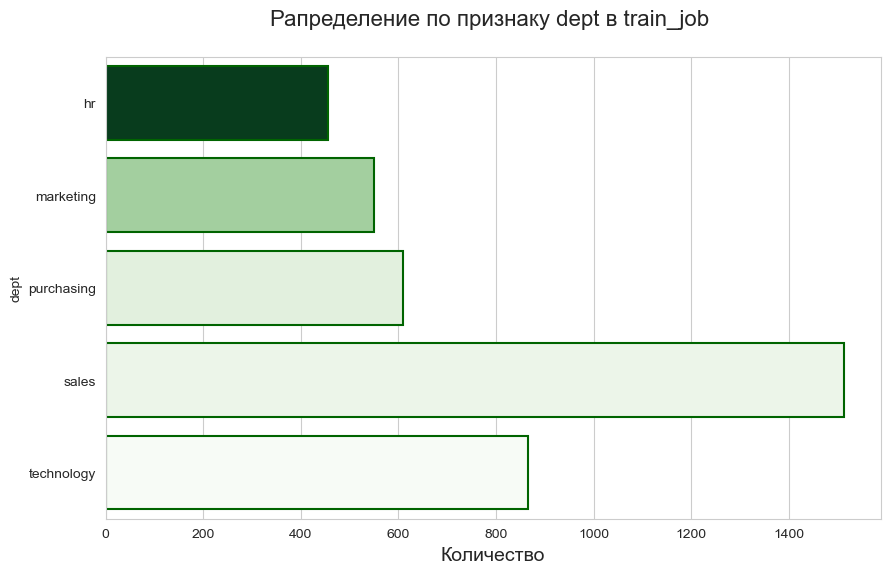

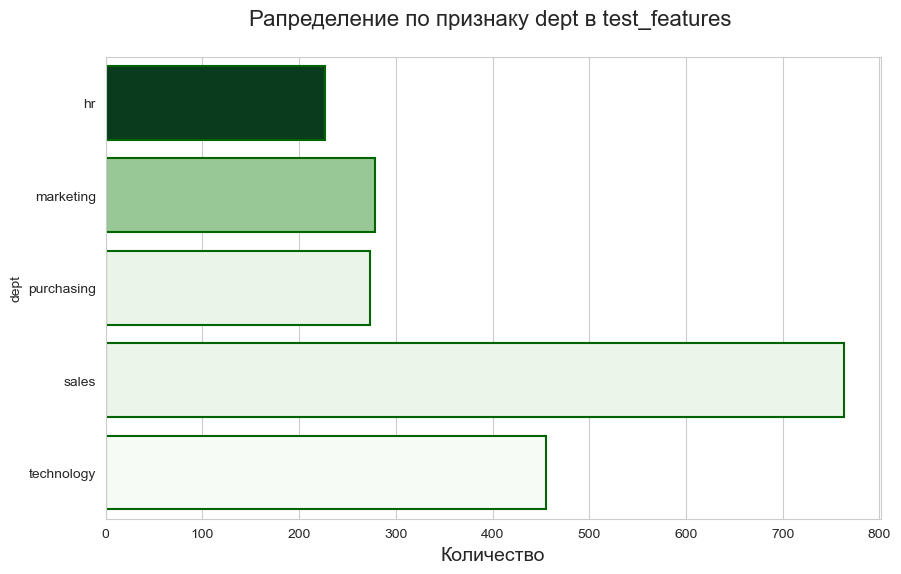

In [17]:
bar_plot_data(train_job, 'dept', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'dept', 'test_features')

в обеих выборках два лидирующих отдела &mdash; `sales` и `technology`, а самый малочисленный &mdash; `hr`. расхождение только в соотношении отделов `purchasing` и `marketing`.

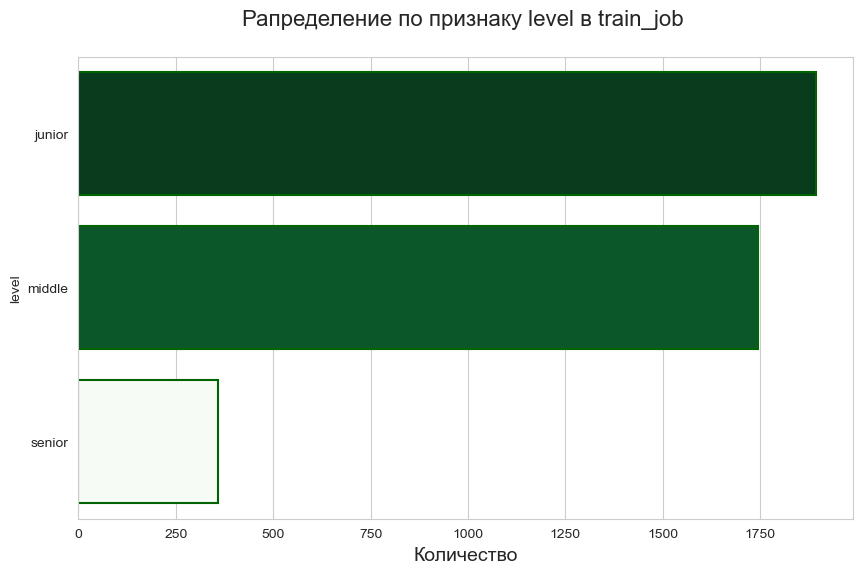

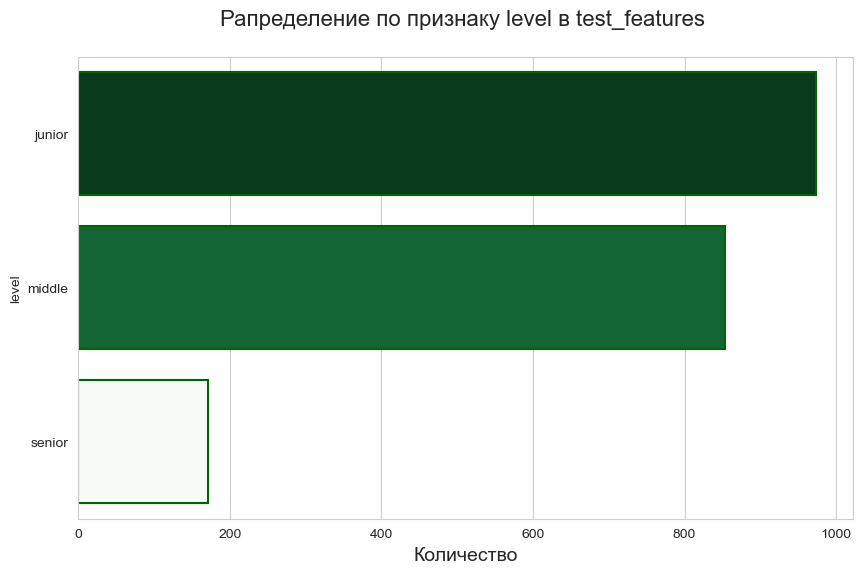

In [18]:
bar_plot_data(train_job, 'level', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'level', 'test_features')

с этой характеристикой всё хорошо: классы распределены пропорционально в обоих датасетах.

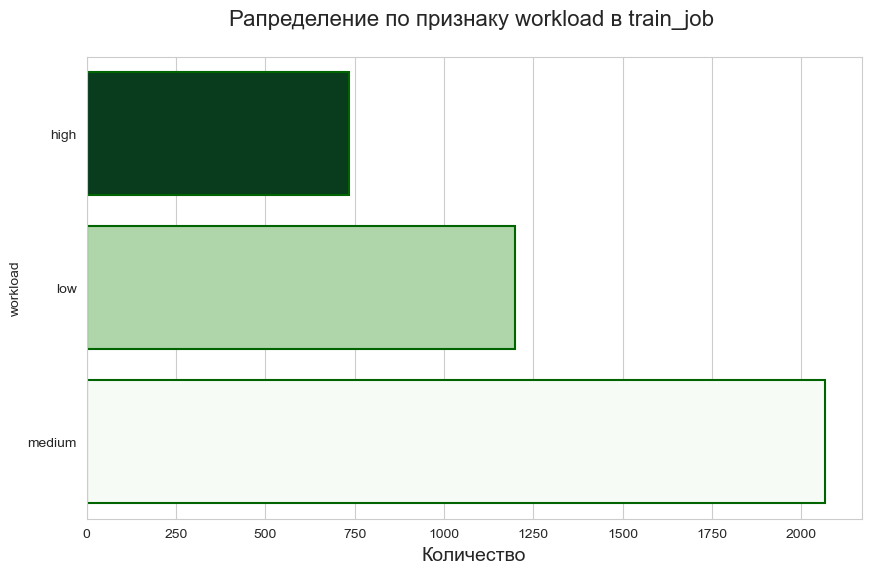

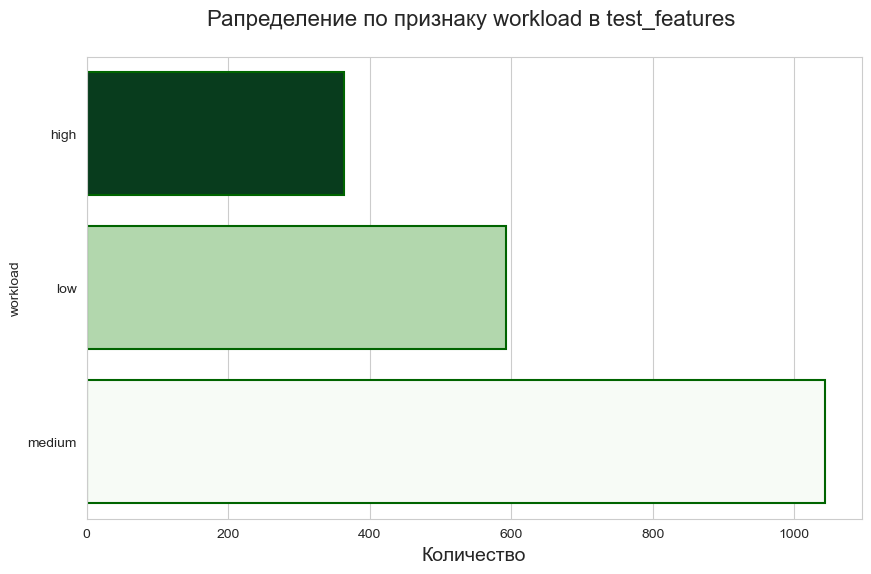

In [19]:
bar_plot_data(train_job, 'workload', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'workload', 'test_features')

признаки распределены пропорционально: в обоих датасетах примерно 20% сотрудников перегружены, можно предположить, что среди недовольных компанией будет немало людей из этого класса.

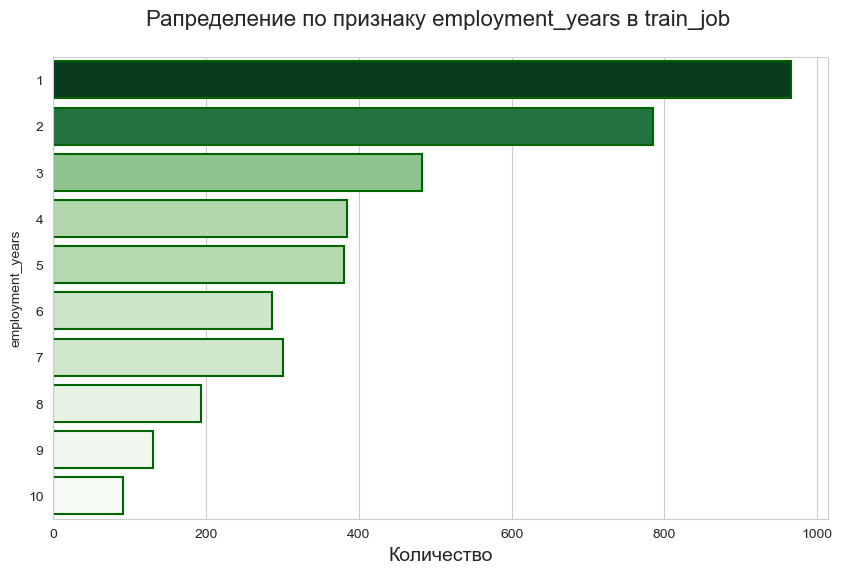

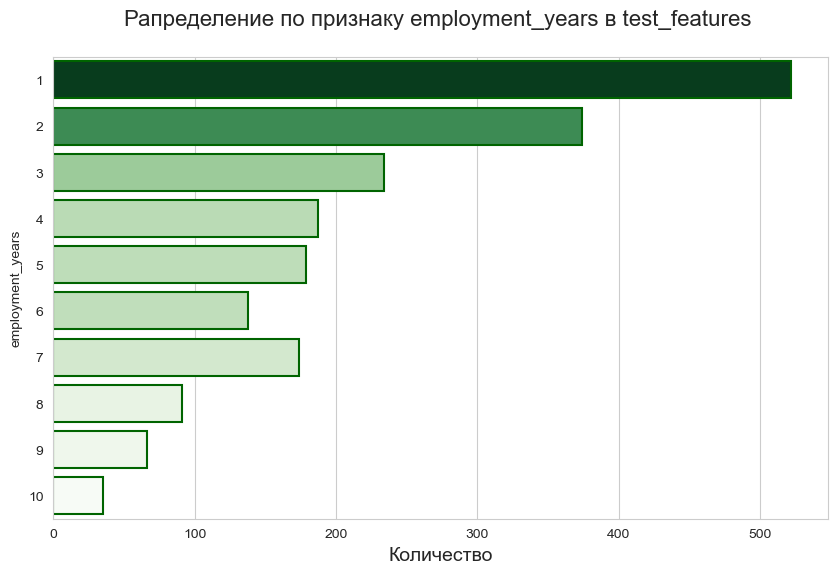

In [20]:
bar_plot_data(train_job, 'employment_years', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'employment_years', 'test_features')

значительное количество сотрудников работают в компании 1-2 года, однако при этом есть заметное количество людей с большим стажем работы.

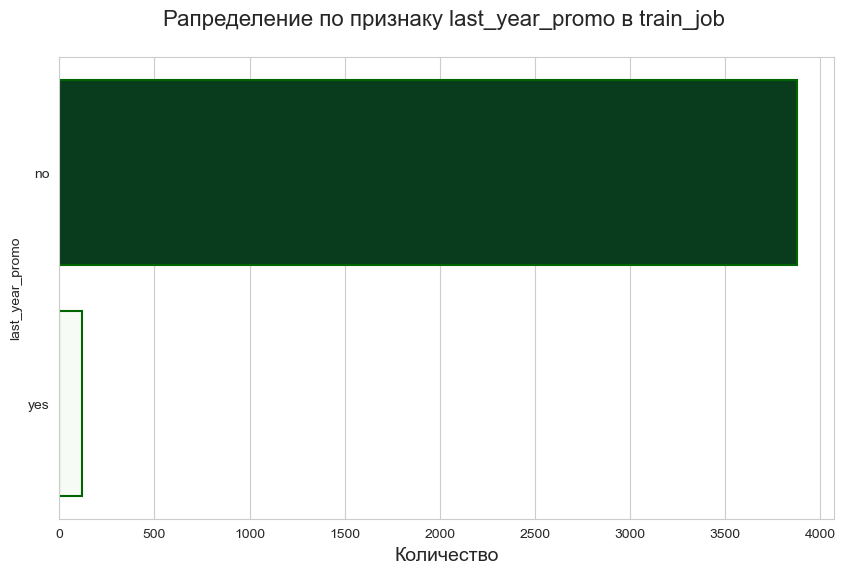

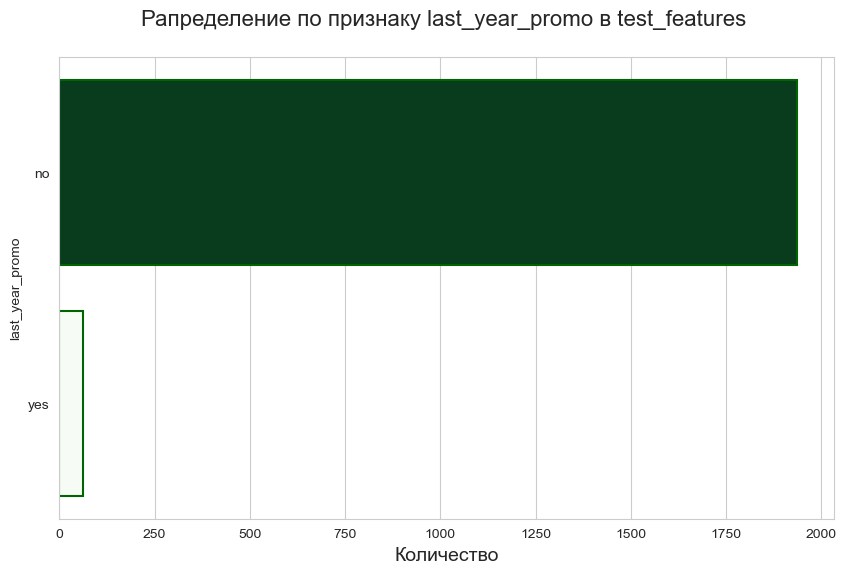

In [21]:
bar_plot_data(train_job, 'last_year_promo', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'last_year_promo', 'test_features')

количество людей, получивших повышение очевидно ниже количества сотрудников, стабильно перегруженных работой. скорее всего, этот момент также является триггерным.<br>
🚩 также сдежует принять во внимание серьёзный дисбаланс классов и учесть при построении модели, в противном случае модель будет игнорировать редкий класс и при этом достигать высокой точности, что делает метрику `accuracy` нерелевантной. в рамках этого исследования будем использовать метрики, чувствительные к распределению классов: например, `ROC-AUC`, `F1-score`, т.к. они отражают способность модели обнаруживать меньший класс. 

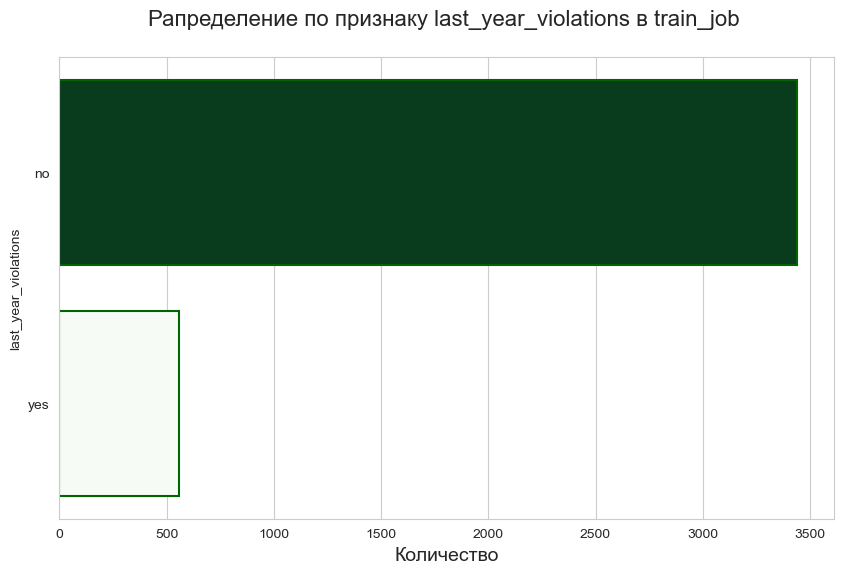

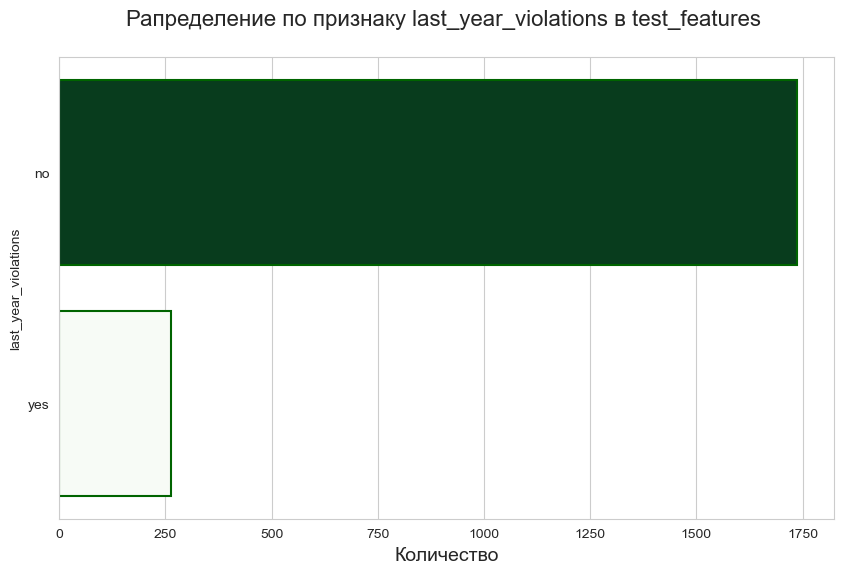

In [22]:
bar_plot_data(train_job, 'last_year_violations', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'last_year_violations', 'test_features')

🚩 снова серьёзный дисбаланс классов, требующий внимания при построении модели.

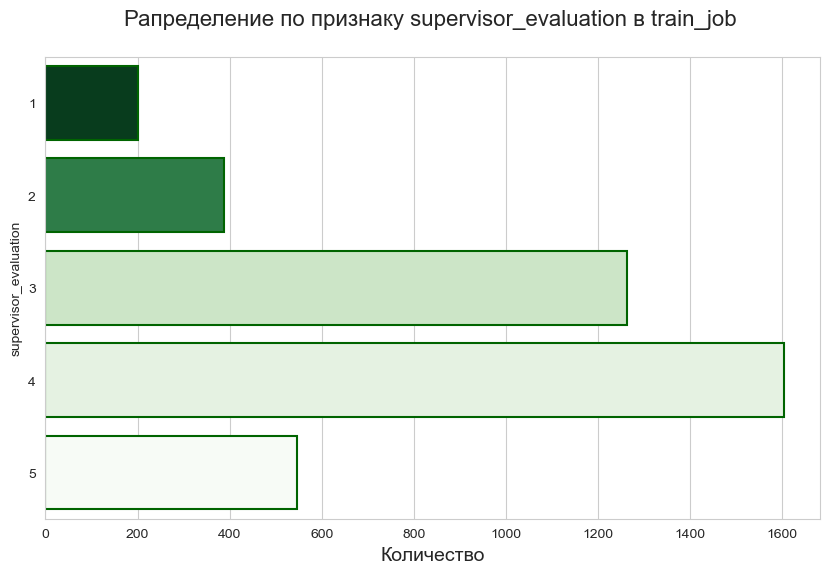

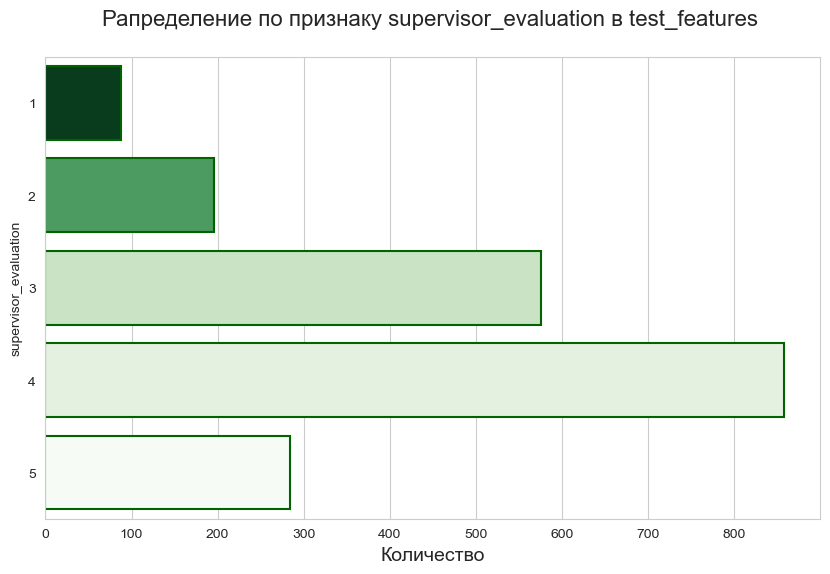

In [23]:
bar_plot_data(train_job, 'supervisor_evaluation', 'train_job')
print("=="*60)
bar_plot_data(test_features, 'supervisor_evaluation', 'test_features')

в целом оценки неплохие: усилия значительной части сотрудников были оценены выше среднего (4-5). давайте проверим, не зафиксированы ли нарушения договора у сотрудников с низкими результатами оценки (1-2):

In [24]:
train_job[(train_job['supervisor_evaluation'].isin([1, 2])) & (train_job['last_year_violations']=='yes')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
34,385514,sales,middle,medium,8,no,yes,2,32400,0.23
64,188350,marketing,middle,high,6,no,yes,1,60000,0.31
87,702721,sales,middle,medium,6,no,yes,1,31200,0.15
157,335445,technology,junior,low,1,no,yes,2,21600,0.23
193,493733,sales,junior,medium,1,no,yes,1,26400,0.18
...,...,...,...,...,...,...,...,...,...,...
3954,706200,purchasing,middle,high,10,no,yes,2,51600,0.13
3964,351063,hr,senior,high,6,no,yes,2,64800,0.16
3972,134106,hr,middle,high,10,no,yes,1,57600,0.39
3978,713279,sales,junior,low,1,no,yes,2,12000,0.09


из почти 600 сотрудников тренировочной выборки только 127 нарушали трудовой договор, похоже, корреляция между этими признаками меньшею чем может показаться на первый взгляд. уделим этим признакам внимание на шаге корреляционного анализа.

Распределение по признаку salary в train_job


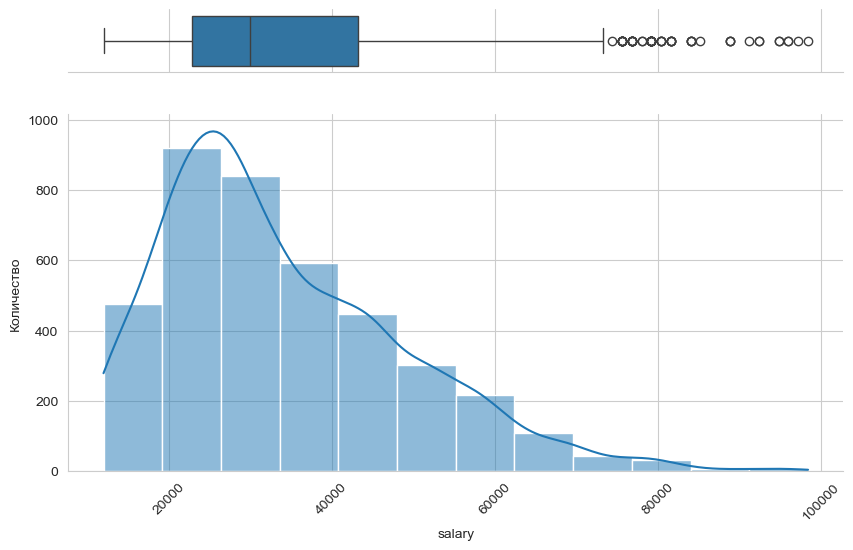

Распределение по признаку salary в test_features


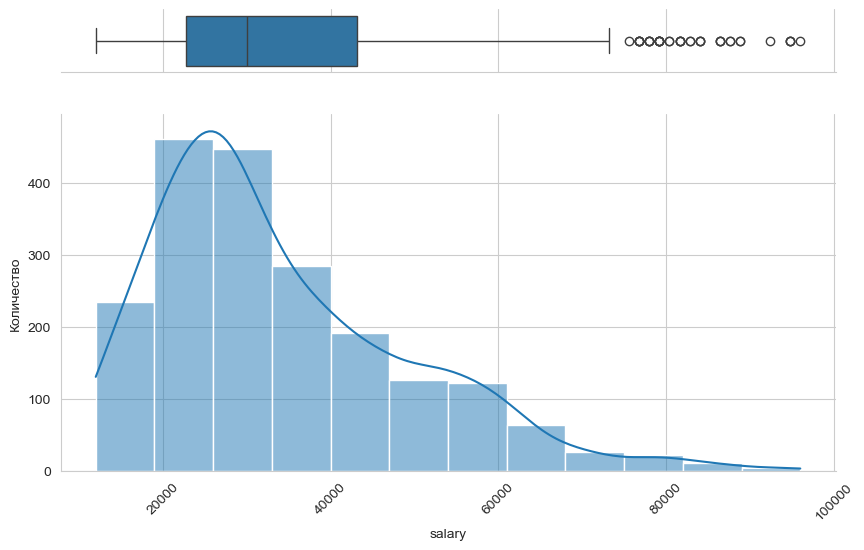

In [25]:
print("Распределение по признаку salary в train_job")
data_box_hist(train_job['salary'])
print("=="*60)
print("Распределение по признаку salary в test_features")
data_box_hist(test_features['salary'])

Распределение по признаку job_satisfaction_rate в train_job


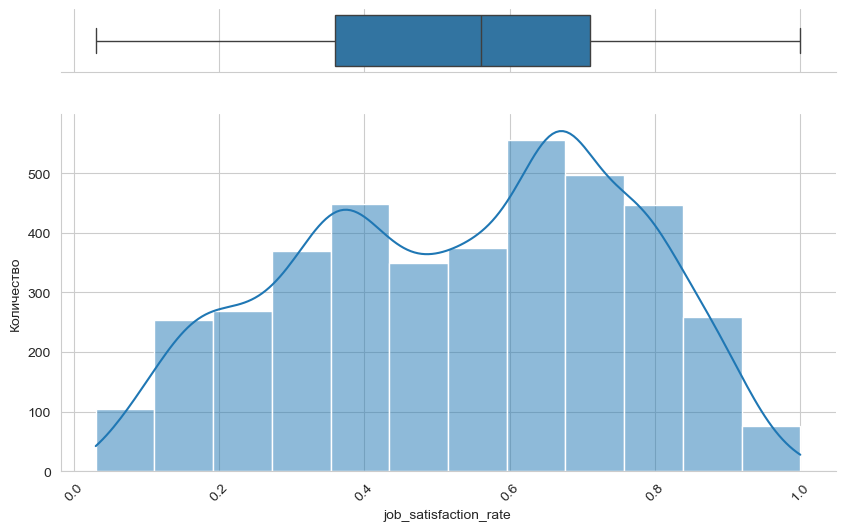

Распределение по признаку job_satisfaction_rate в test_target_job


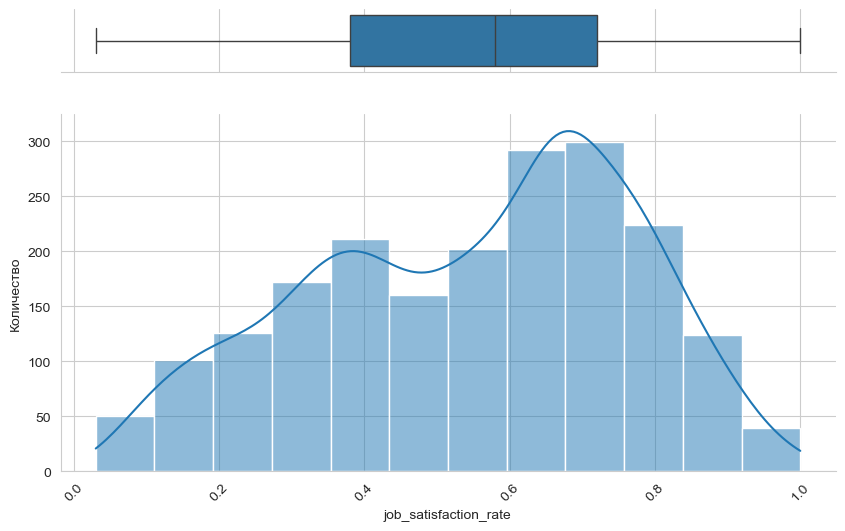

In [26]:
print("Распределение по признаку job_satisfaction_rate в train_job")
data_box_hist(train_job['job_satisfaction_rate'])
print("=="*60)
print("Распределение по признаку job_satisfaction_rate в test_target_job")
data_box_hist(test_target_job['job_satisfaction_rate'])

распределение оценок удовлетворённости не вызывает серьёзных опасений, однако обратим внимание, что в целевом датасете высоких оценок больше, чем в тренировочном.

в целом распределение данных в тестовой и тренировочной выборках практически идентичное, что говорит о хорошей представительности данных и возможности использовать их для обучения модели.

### Корреляционный анализ

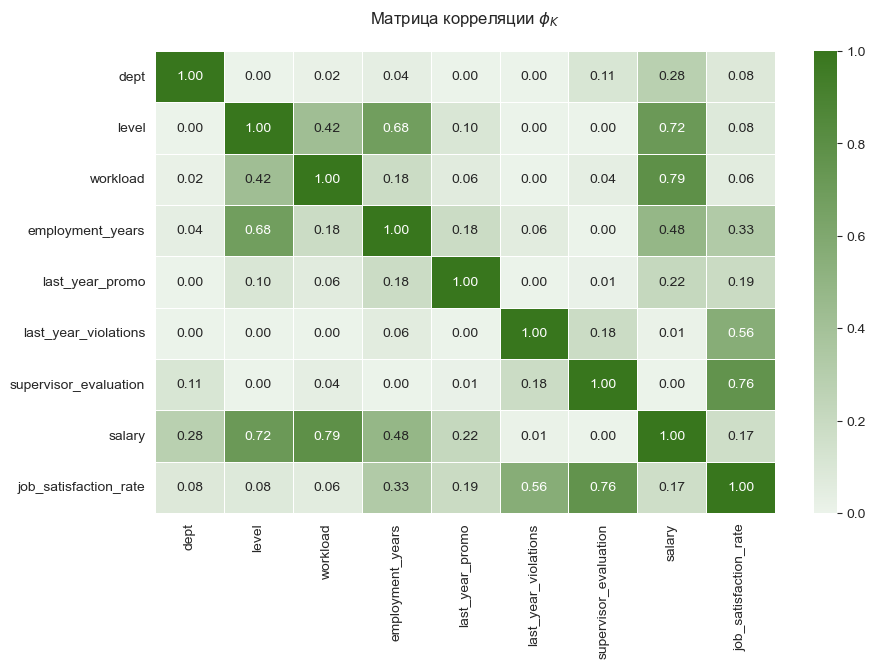

In [27]:
phik_train_job = train_job.drop(columns = ['id'], axis = 1)
interval_columns = ['salary', 'job_satisfaction_rate']
phik_overview = phik_train_job.phik_matrix(interval_cols=interval_columns)

green_cmap = sns.light_palette("#38761d", as_cmap=True)
#sns.set(rc={"figure.figsize": (12, 9)})
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5)
plt.title('Матрица корреляции $\phi_K$ \n')
plt.show()

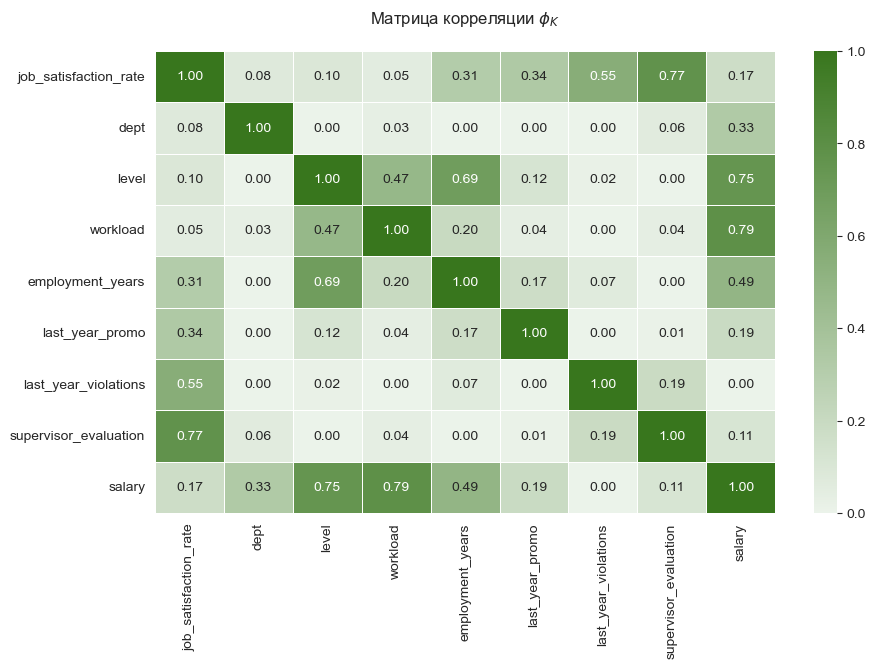

In [28]:
full_test = test_target_job.merge(test_features, on='id', how='left')
#matrix_corr = full_test.drop('id', axis=1).phik_matrix()

phik_full_test = full_test.drop(columns = ['id'], axis = 1)
interval_columns = ['salary', 'job_satisfaction_rate']
phik_overview = phik_full_test.phik_matrix(interval_cols=interval_columns)

green_cmap = sns.light_palette("#38761d", as_cmap=True)
#sns.set(rc={"figure.figsize": (12, 9)})
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5)
plt.title('Матрица корреляции $\phi_K$ \n')
plt.show()

между некоторыми признаками наблюдается корреляция, но нигде уровень не превышает 0.8<br>
проверим данные на мультиколлинеарность.

In [30]:
numeric_data = train_job.select_dtypes(include=[np.number])
category_data = train_job.select_dtypes(include=['category'])

category_ohe = pd.get_dummies(category_data, drop_first=True).astype(int)

X_encoded = pd.concat([numeric_data, category_ohe], axis=1)

X_encoded = X_encoded.astype(float)

X = sm.add_constant(X_encoded.iloc[:, 1:])

VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIFs.sort_values(by="VIF", ascending=False))

                    Variable         VIF
0                      const  123.026959
1                     salary   14.909724
9               workload_low   12.608307
24   supervisor_evaluation_4    9.232261
8               level_senior    7.233237
2      job_satisfaction_rate    6.546537
7               level_middle    6.353987
10           workload_medium    5.547507
25   supervisor_evaluation_5    5.179469
23   supervisor_evaluation_3    5.058013
5                 dept_sales    2.715418
22   supervisor_evaluation_2    2.654485
6            dept_technology    2.627542
16        employment_years_7    2.269821
14        employment_years_5    2.216761
15        employment_years_6    2.113250
4            dept_purchasing    1.988163
3             dept_marketing    1.916763
17        employment_years_8    1.856587
11        employment_years_2    1.785753
18        employment_years_9    1.610441
12        employment_years_3    1.594759
13        employment_years_4    1.575308
19       employm

мы видим, что классы некоторых признаков провоцируют мультиколлинеарность, однако у нас не так много признаков, чтобы избавляться от них. однако мы учтём эту проблему: помимо линейной модели мы будем применять дерево решений. этот метод нечувствиителен к мультиколлинеарности и лучше находит нелинейные взаимосвязи между признаками.

### Подготовка данных и построение пайплайна

In [31]:
full_test.info()
full_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     2000 non-null   int64   
 1   job_satisfaction_rate  2000 non-null   float64 
 2   dept                   1997 non-null   category
 3   level                  1999 non-null   category
 4   workload               1999 non-null   category
 5   employment_years       2000 non-null   category
 6   last_year_promo        2000 non-null   category
 7   last_year_violations   2000 non-null   category
 8   supervisor_evaluation  2000 non-null   category
 9   salary                 2000 non-null   int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 62.0 KB


,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000


разделим датасет на обучающую и тестовую выборки:

In [32]:
X_train = train_job.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job['job_satisfaction_rate']
X_test = full_test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = full_test['job_satisfaction_rate']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 8)
(2000, 8)
(4000,)
(2000,)


построим пайплайн

In [33]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

In [34]:
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [35]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        ('ord',
        OrdinalEncoder(categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']],
                       handle_unknown='use_encoded_value',
                       unknown_value=np.nan)
        ),
        
        ('simpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [36]:
data_preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough'
)

In [37]:
pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', LinearRegression())
])

In [38]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 20),
        'models__max_features': ['sqrt', 'log2', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 150],
        'models__learning_rate': [0.05, 0.1],
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [39]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [40]:
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

### Обучение модели

In [41]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer,
    error_score='raise'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [GradientBoostingRegressor(random_state=42)],
                          'models__learning_rate': [0.05, 0.1],
                          'models__max_depth': [3, 5],
                          'models__n_estimators': [100, 150],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [42]:
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', 
       round(grid_search.best_score_*(-1), 2)
      )

print(grid_search.best_params_)

Метрика SMAPE лучшей модели на тренировочной выборке: 11.64
{'models': GradientBoostingRegressor(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 150, 'preprocessor__num': 'passthrough'}


полученный результат укладывается в критерий успеха: `SMAPE ≤ 15` на тестовой выборке.

### Тестирование и вывод

In [43]:
print('Метрика SMAPE лучшей модели на тестовой выборке:', 
      round(smape(y_test, grid_search.best_estimator_.predict(X_test)),2)
     )

Метрика SMAPE лучшей модели на тестовой выборке: 11.0


Можно сделать следующие выводы:

* Лучшей моделью оказалась GradientBoostingRegressor со следующими параметрами: max_depth=5, n_estimators=150, learning_rate=0.1
* Метрика SMAPE лучшей модели на тренировочной выборке составила 11.64.
* Метрика SMAPE лучшей модели на тестовой выборке составила 11.0.
* Таким образом, мы обучили модель предсказывать уровень удовлетворённости сотрудника с точностью 11.0/11.64.

## задача II: прогнозирование увольнений
### ознакомление с данными

In [44]:
try:
    train_quit = pd.read_csv('D:\docs\DS\train_quit.csv')
    test_features = pd.read_csv('D:\docs\DS\test_features.csv')
    test_target_quit = pd.read_csv('D:\docs\DS\test_target_quit.csv')
    
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [45]:
print('Тренировочная выборка \n')
train_quit.info()
display(train_quit.describe())
train_quit.head()

Тренировочная выборка 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [46]:
print('Входные признаки тестовой выборки \n')
test_features.info()
display(test_features.describe())
test_features.head()

Входные признаки тестовой выборки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [47]:
print('Целевой признак тестовой выборки \n')
test_target_quit.info()
display(test_target_quit.describe())
test_target_quit.head()

Целевой признак тестовой выборки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


как и в первой задаче:

✔️ датасет соответствует описанию, названия признаков заданы корректно;<br>
🚩 есть незначительное количество пропусков, с которыми справимся с помощью SimpleImputer<br>
🚩 не везде тип данных определён корректно: например, переменную `employment_years` лучше перевести в категориальный тип

### предобработка данных
начнём с проверки на полные дубликаты:

In [48]:
print(f"Количество дубликатов в train_quit:       {train_quit.duplicated().sum()} \n"
      f"Количество дубликатов в test_features:    {test_features.duplicated().sum()}\n"
      f"Количество дубликатов в test_target_quit: {test_target_quit.duplicated().sum()}"
     )

Количество дубликатов в train_quit:       0 
Количество дубликатов в test_features:    0
Количество дубликатов в test_target_quit: 0


In [49]:
train_quit[train_quit.drop('id', axis=1).duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
117,873412,technology,junior,medium,2,no,no,4,31200,no
152,749683,sales,middle,low,8,no,no,4,19200,no
175,689526,marketing,middle,low,6,no,no,3,30000,no
205,786443,purchasing,middle,low,6,no,no,4,19200,no
254,362060,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...,...
3990,632886,sales,junior,low,3,no,no,4,12000,no
3993,387733,marketing,middle,medium,5,no,no,3,44400,no
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no


In [50]:
test_features[test_features.drop('id', axis=1).duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
30,523542,marketing,junior,low,1,no,no,3,16800
56,582128,sales,middle,high,5,no,no,4,48000
62,482624,technology,middle,medium,4,yes,no,2,44400
111,770429,hr,junior,medium,1,no,no,4,30000
113,761490,sales,junior,low,1,no,no,4,15600
...,...,...,...,...,...,...,...,...,...
1992,760964,sales,junior,medium,3,no,no,5,21600
1993,380255,sales,middle,medium,8,no,no,4,38400
1995,393147,marketing,junior,low,3,no,no,3,20400
1997,305653,technology,junior,low,1,no,no,3,14400


In [51]:
print(f"Уникальные значения: \n"
      f"переменная level, датасет train_quit:       {train_quit['level'].unique()} \n"
      f"переменная level, датасет test_features:    {test_features['level'].unique()} \n \n"
      f"переменная dept, датасет train_quit:        {train_quit['dept'].unique()} \n"
      f"переменная dept, датасет test_features:     {test_features['dept'].unique()} \n \n"      
      f"переменная workload, датасет train_quit:    {train_quit['workload'].unique()} \n"
      f"переменная workload, датасет test_features: {test_features['workload'].unique()}"
     )

Уникальные значения: 
переменная level, датасет train_quit:       ['middle' 'junior' 'sinior'] 
переменная level, датасет test_features:    ['junior' 'middle' 'sinior' nan] 
 
переменная dept, датасет train_quit:        ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 
переменная dept, датасет test_features:     ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 
 
переменная workload, датасет train_quit:    ['high' 'medium' 'low'] 
переменная workload, датасет test_features: ['medium' 'low' 'high' ' ']


In [52]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

print(f"Уникальные значения: \n"
      f"переменная level, датасет train_quit:        {train_quit['level'].unique()} \n"
      f"переменная level, датасет test_features:     {test_features['level'].unique()} \n \n"
      f"переменная dept, датасет train_quit:         {train_quit['dept'].unique()} \n"
      f"переменная dept, датасет test_features:      {test_features['dept'].unique()} \n \n"      
      f"переменная workload, датасет train_quit:     {train_quit['workload'].unique()} \n"
      f"переменная workload, датасет test_features:  {test_features['workload'].unique()}"
     )

Уникальные значения: 
переменная level, датасет train_quit:        ['middle' 'junior' 'senior'] 
переменная level, датасет test_features:     ['junior' 'middle' 'senior' nan] 
 
переменная dept, датасет train_quit:         ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 
переменная dept, датасет test_features:      ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan] 
 
переменная workload, датасет train_quit:     ['high' 'medium' 'low'] 
переменная workload, датасет test_features:  ['medium' 'low' 'high' nan]


In [53]:
# напишем цикл, который задаст новый тип данных для нужных столбцов:
category_columns = ['dept', 
                    'level', 
                    'workload', 
                    'employment_years', 
                    'last_year_promo', 
                    'last_year_violations', 
                    'supervisor_evaluation',
                    'quit']

for column in category_columns:
    if column in train_quit.columns:
        train_quit[column] = train_quit[column].astype('category')
    if column in test_features.columns:
        test_features[column] = test_features[column].astype('category')

In [54]:
train_quit.info()
print("=="*30)
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     4000 non-null   int64   
 1   dept                   4000 non-null   category
 2   level                  4000 non-null   category
 3   workload               4000 non-null   category
 4   employment_years       4000 non-null   category
 5   last_year_promo        4000 non-null   category
 6   last_year_violations   4000 non-null   category
 7   supervisor_evaluation  4000 non-null   category
 8   salary                 4000 non-null   int64   
 9   quit                   4000 non-null   category
dtypes: category(8), int64(2)
memory usage: 95.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  --

в рамках предобработки данных:<br>
✔️ задали корректный тип данных для категориальных переменных;<br>
✔️ проверили данные на дубликаты;<br>
🚩 исправили опечатки в данных и некорректное обозначение nan

### исследовательский анализ
как и в первой части исследования, построим ряд графиков, чтобы наглядно оценить подобие тестовой и тренировочной выборок:

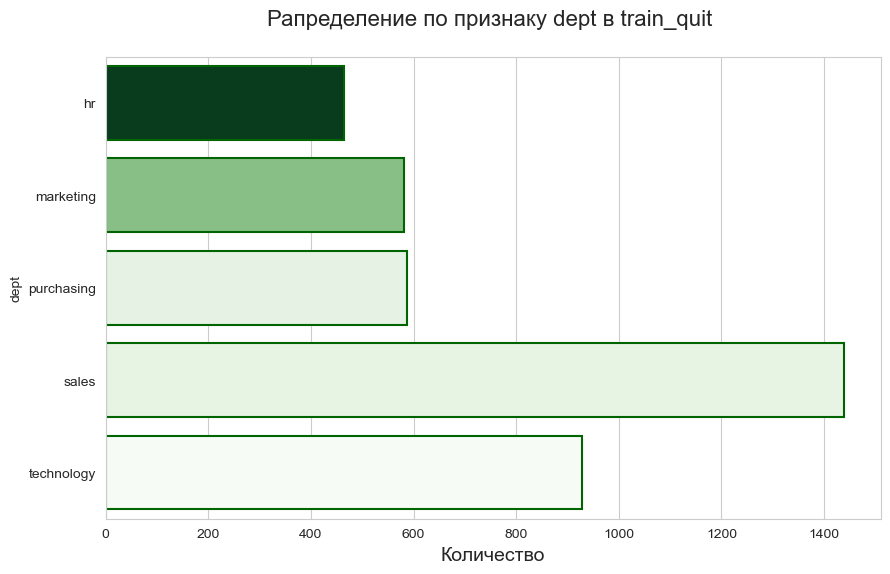

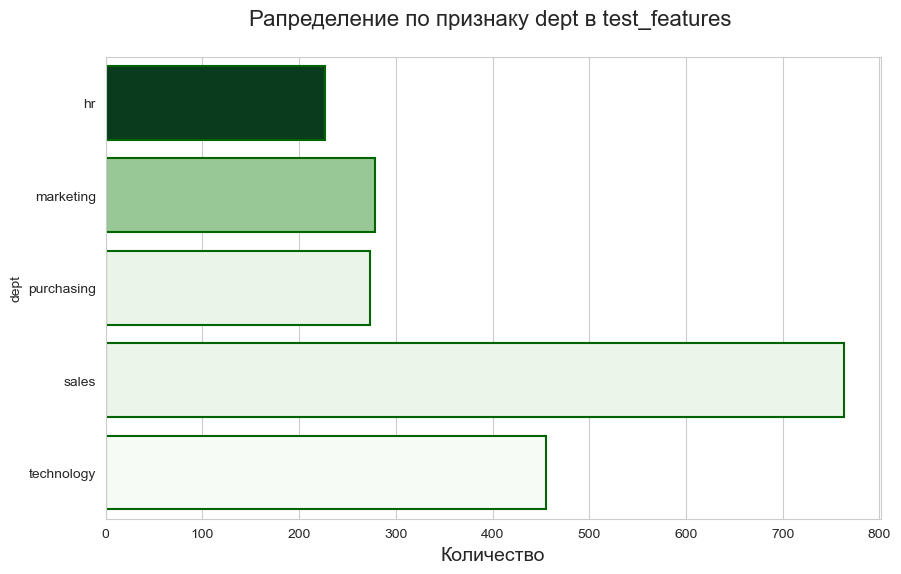

In [55]:
bar_plot_data(train_quit, 'dept', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'dept', 'test_features')

с заметным отрывом от остальных коллег увольняются сотрудники отдела продаж.

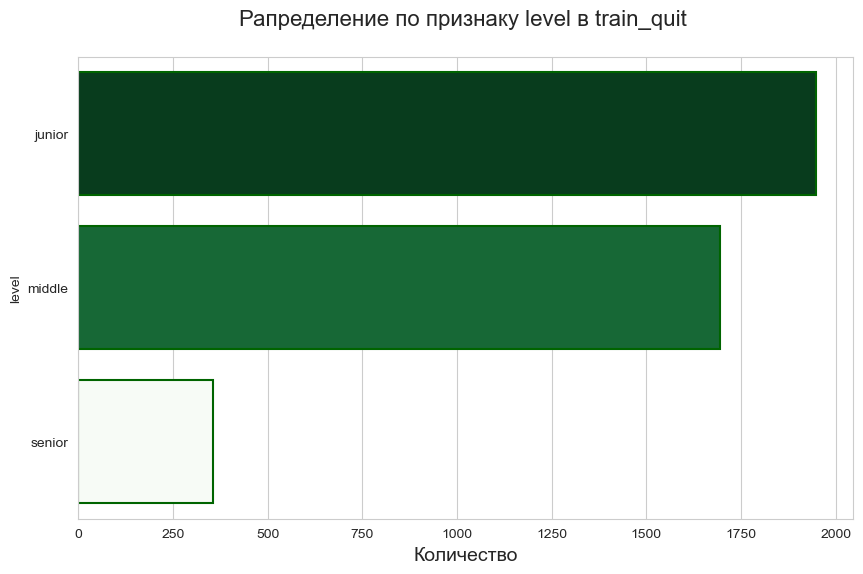

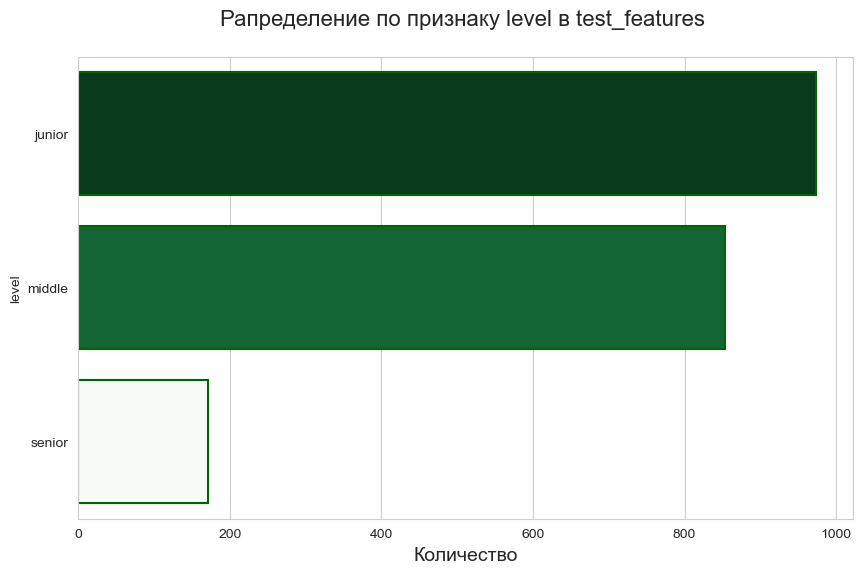

In [56]:
bar_plot_data(train_quit, 'level', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'level', 'test_features')

основная текучка среди джунов, в целом ожидаемо.

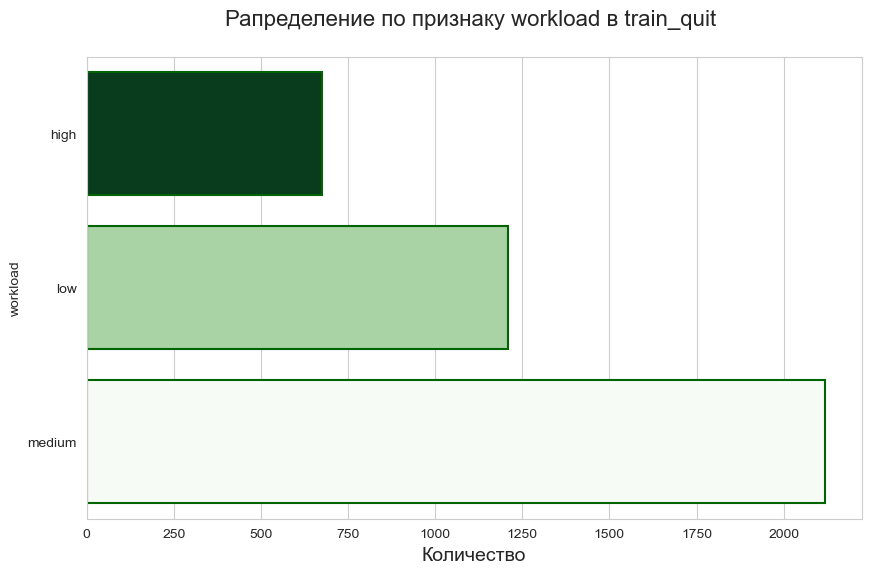

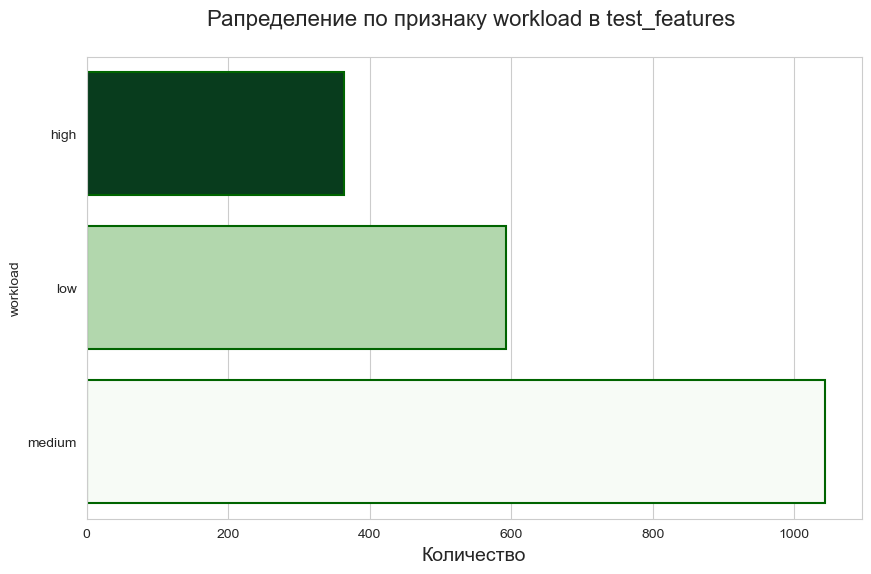

In [57]:
bar_plot_data(train_quit, 'workload', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'workload', 'test_features')

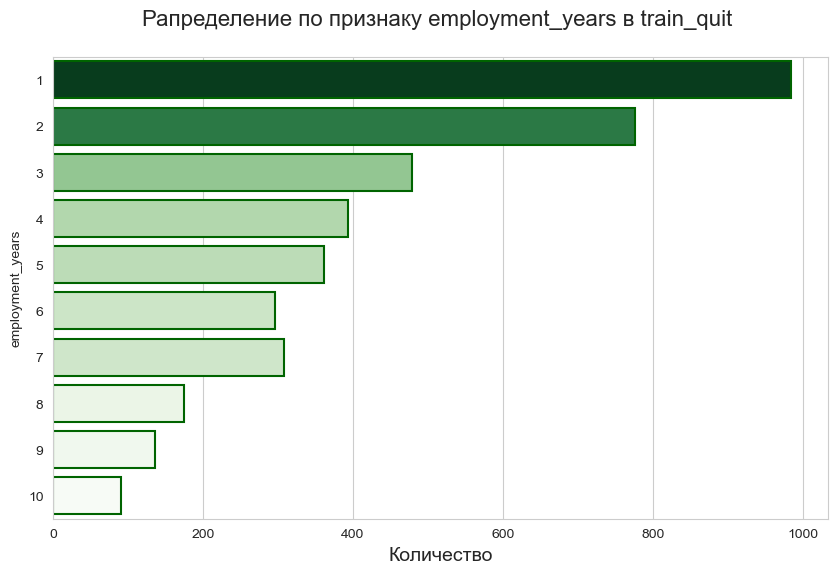

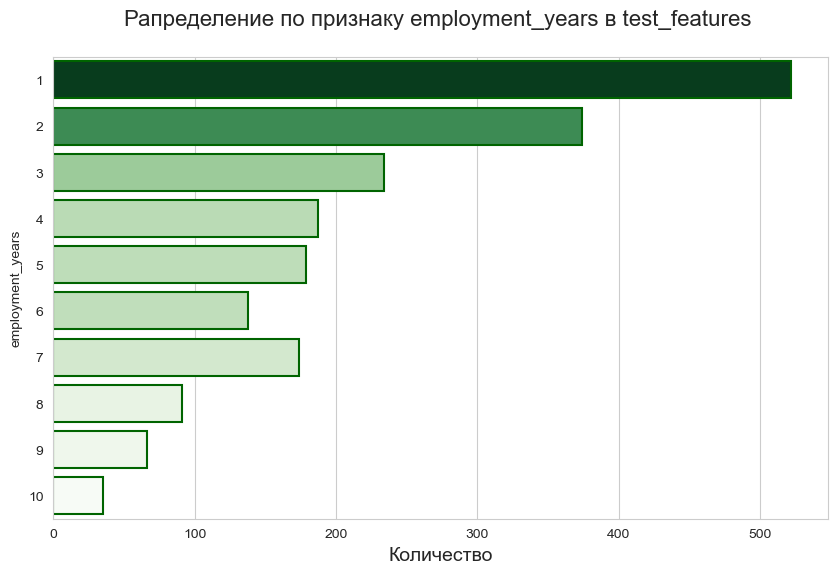

In [58]:
bar_plot_data(train_quit, 'employment_years', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'employment_years', 'test_features')

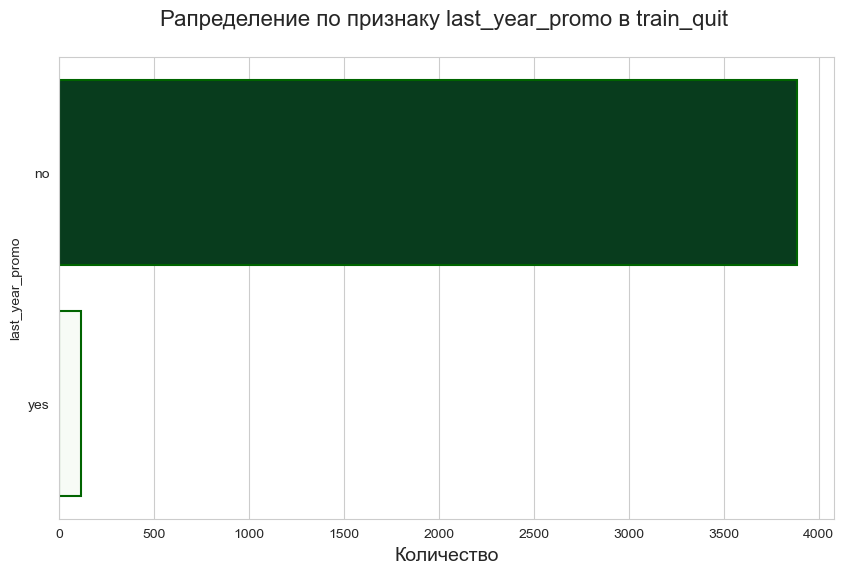

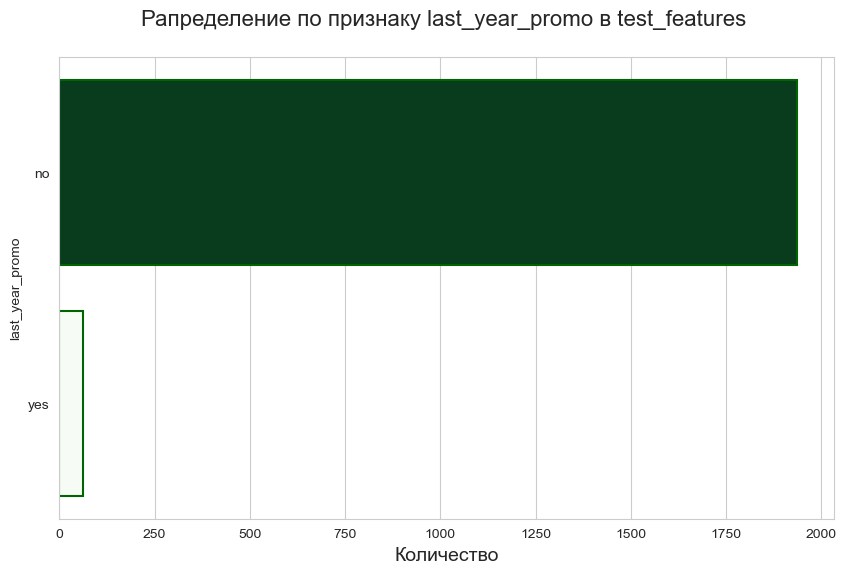

In [59]:
bar_plot_data(train_quit, 'last_year_promo', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'last_year_promo', 'test_features')

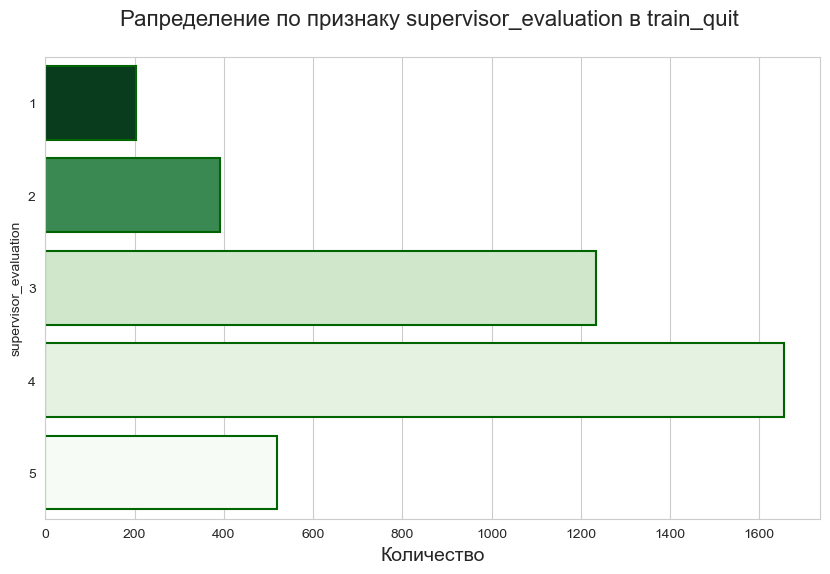

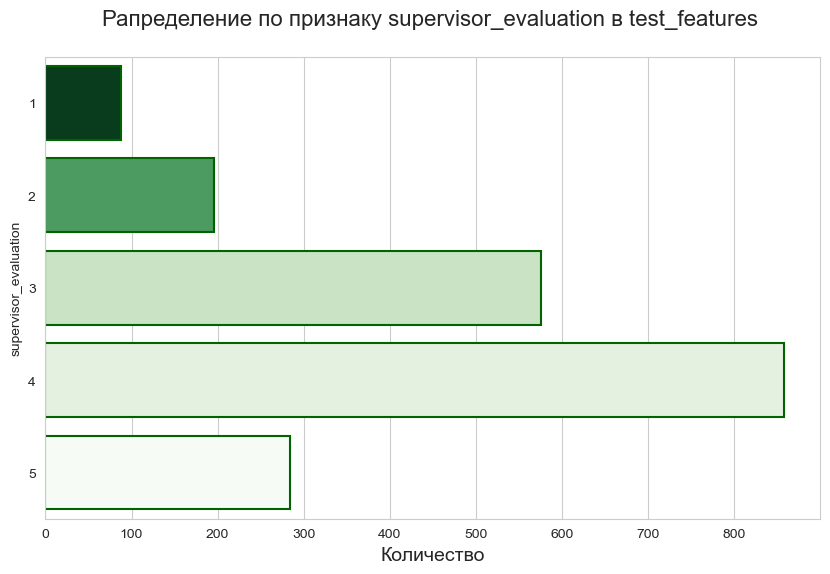

In [60]:
bar_plot_data(train_quit, 'supervisor_evaluation', 'train_quit')
print("=="*60)
bar_plot_data(test_features, 'supervisor_evaluation', 'test_features')

Распределение по признаку salary в train_quit


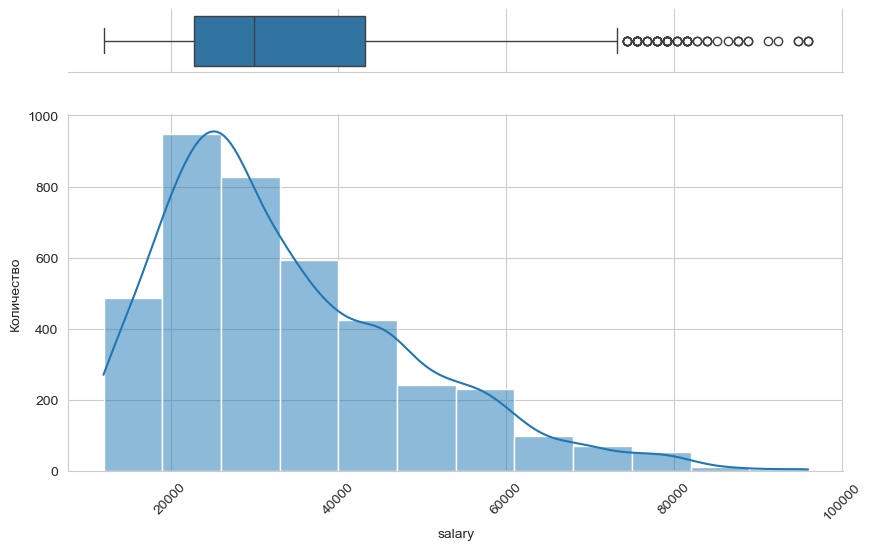

Распределение по признаку salary в test_features


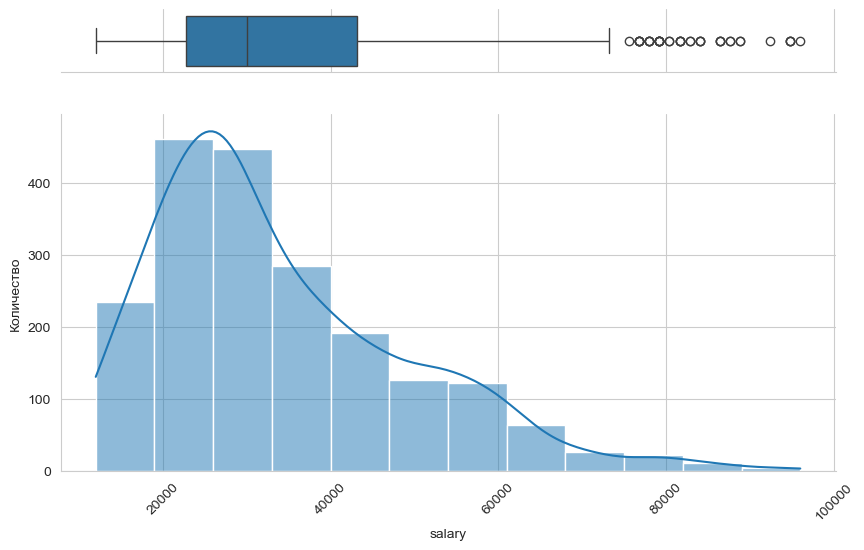

In [61]:
print("Распределение по признаку salary в train_quit")
data_box_hist(train_quit['salary'])
print("=="*60)
print("Распределение по признаку salary в test_features")
data_box_hist(test_features['salary'])

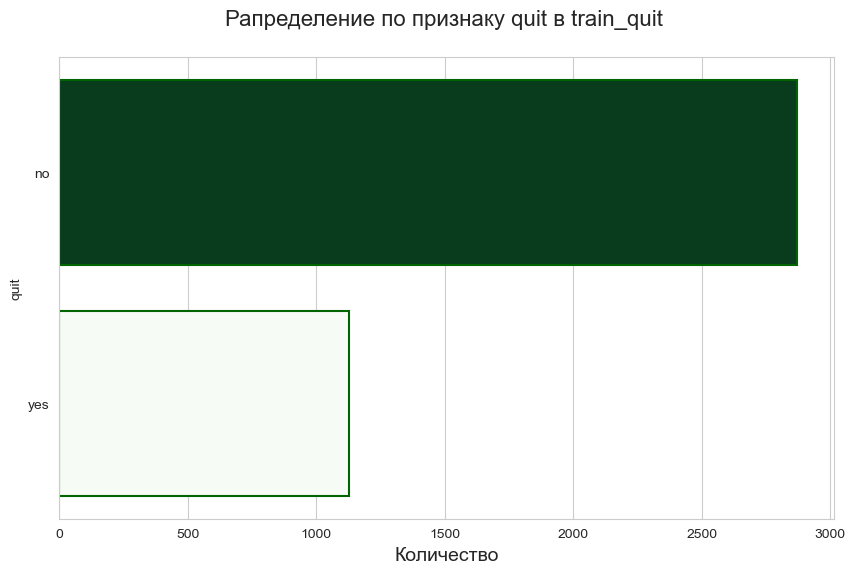

In [62]:
bar_plot_data(train_quit, 'quit', 'train_quit')

почти треть тренировочной выборки &mdash; уволившиеся сотрудники, довольно много.

общий вывод из увиденного на графиках <br>
🚩 серьёзный дисбаланс классов. надо учесть при построении модели, в противном случае будет проигнорирован редкий класс и при этом достигнута ложная высокая точность. будем использовать метрику ROC-AUC.<br>
✔️ в целом распределение данных в тестовой и тренировочной выборках практически идентичное, что говорит о хорошей представительности данных и возможности использовать их для обучения модели.

#### Портрет уволившегося сотрудника

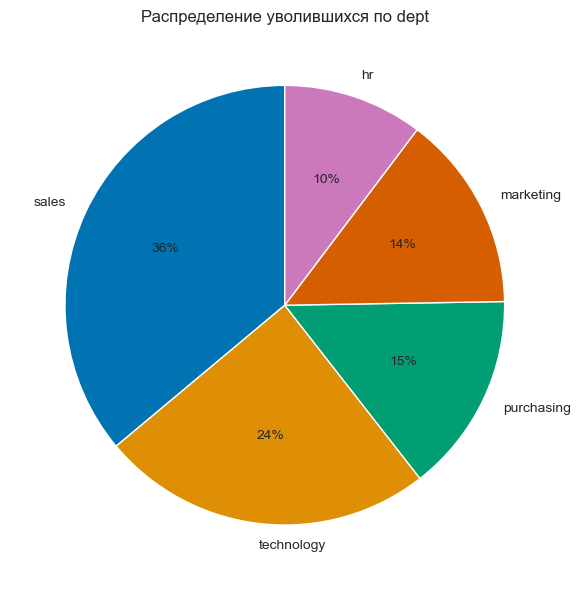

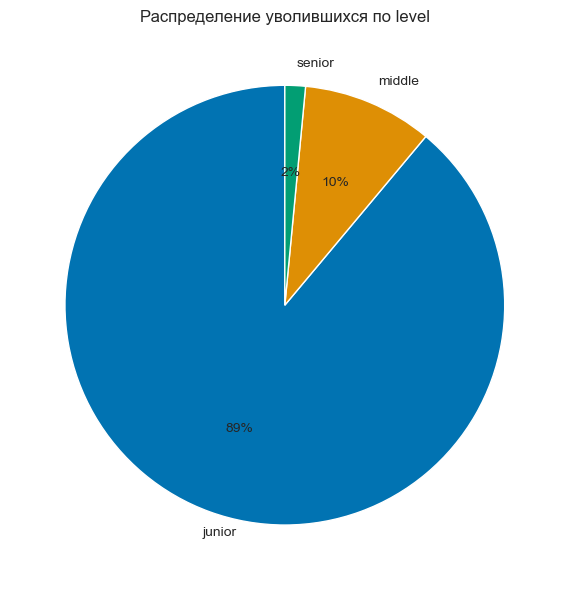

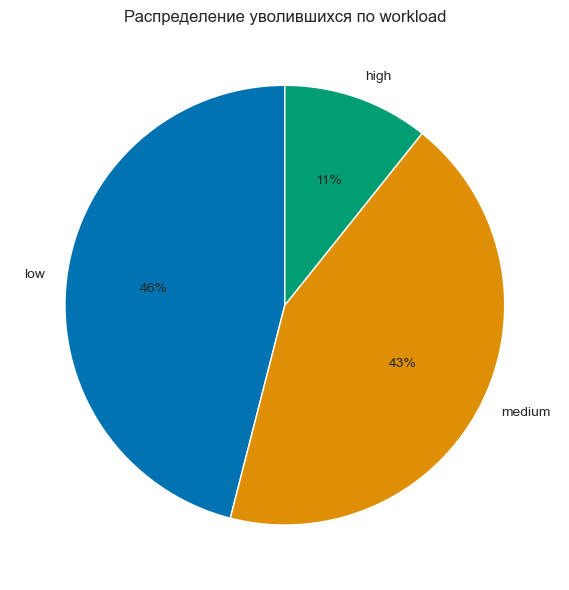

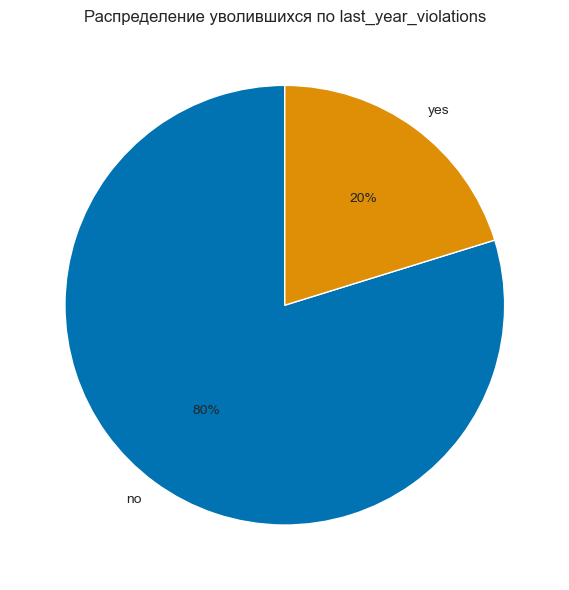

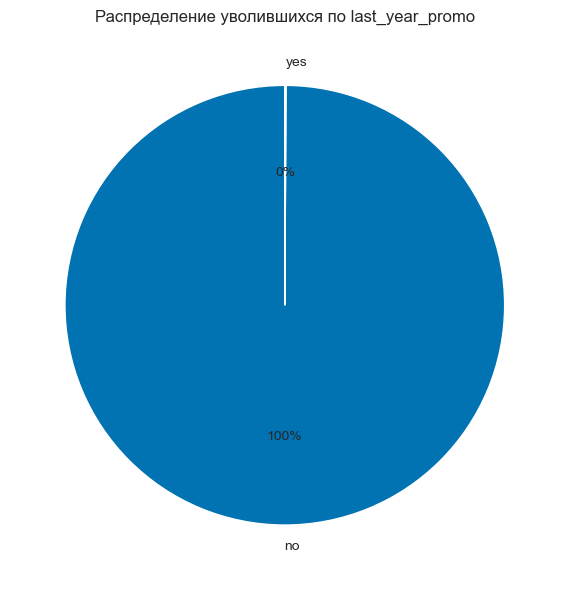

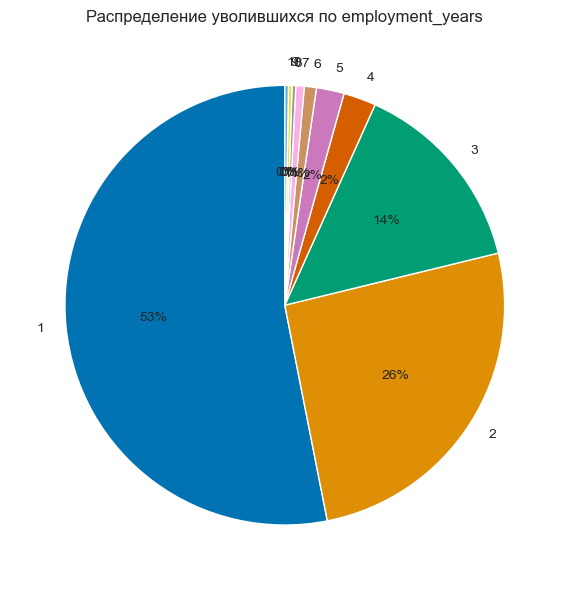

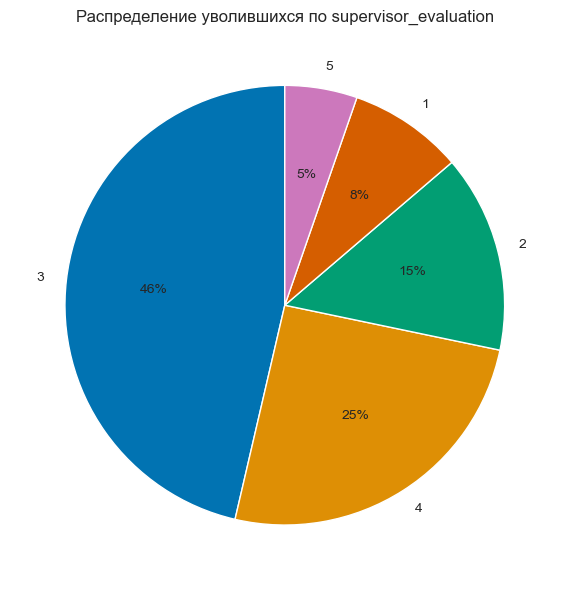

In [63]:
category_columns = ['dept', 
                    'level', 
                    'workload',
                    'last_year_violations',
                    'last_year_promo',
                    'employment_years',
                    'supervisor_evaluation'
                    ]

for column in category_columns:
    pie_hard(train_quit[train_quit['quit'] == 'yes'], column, 'train_quit')

портрет почти готов, остался самый чувствительный момент: зарплаты. давайте посмотрим на соотношение зарплат уволившихся и оставшихся сотрудников в разрезе нескольких категорий: отдел, грейд, загруженность и оценка шефа.

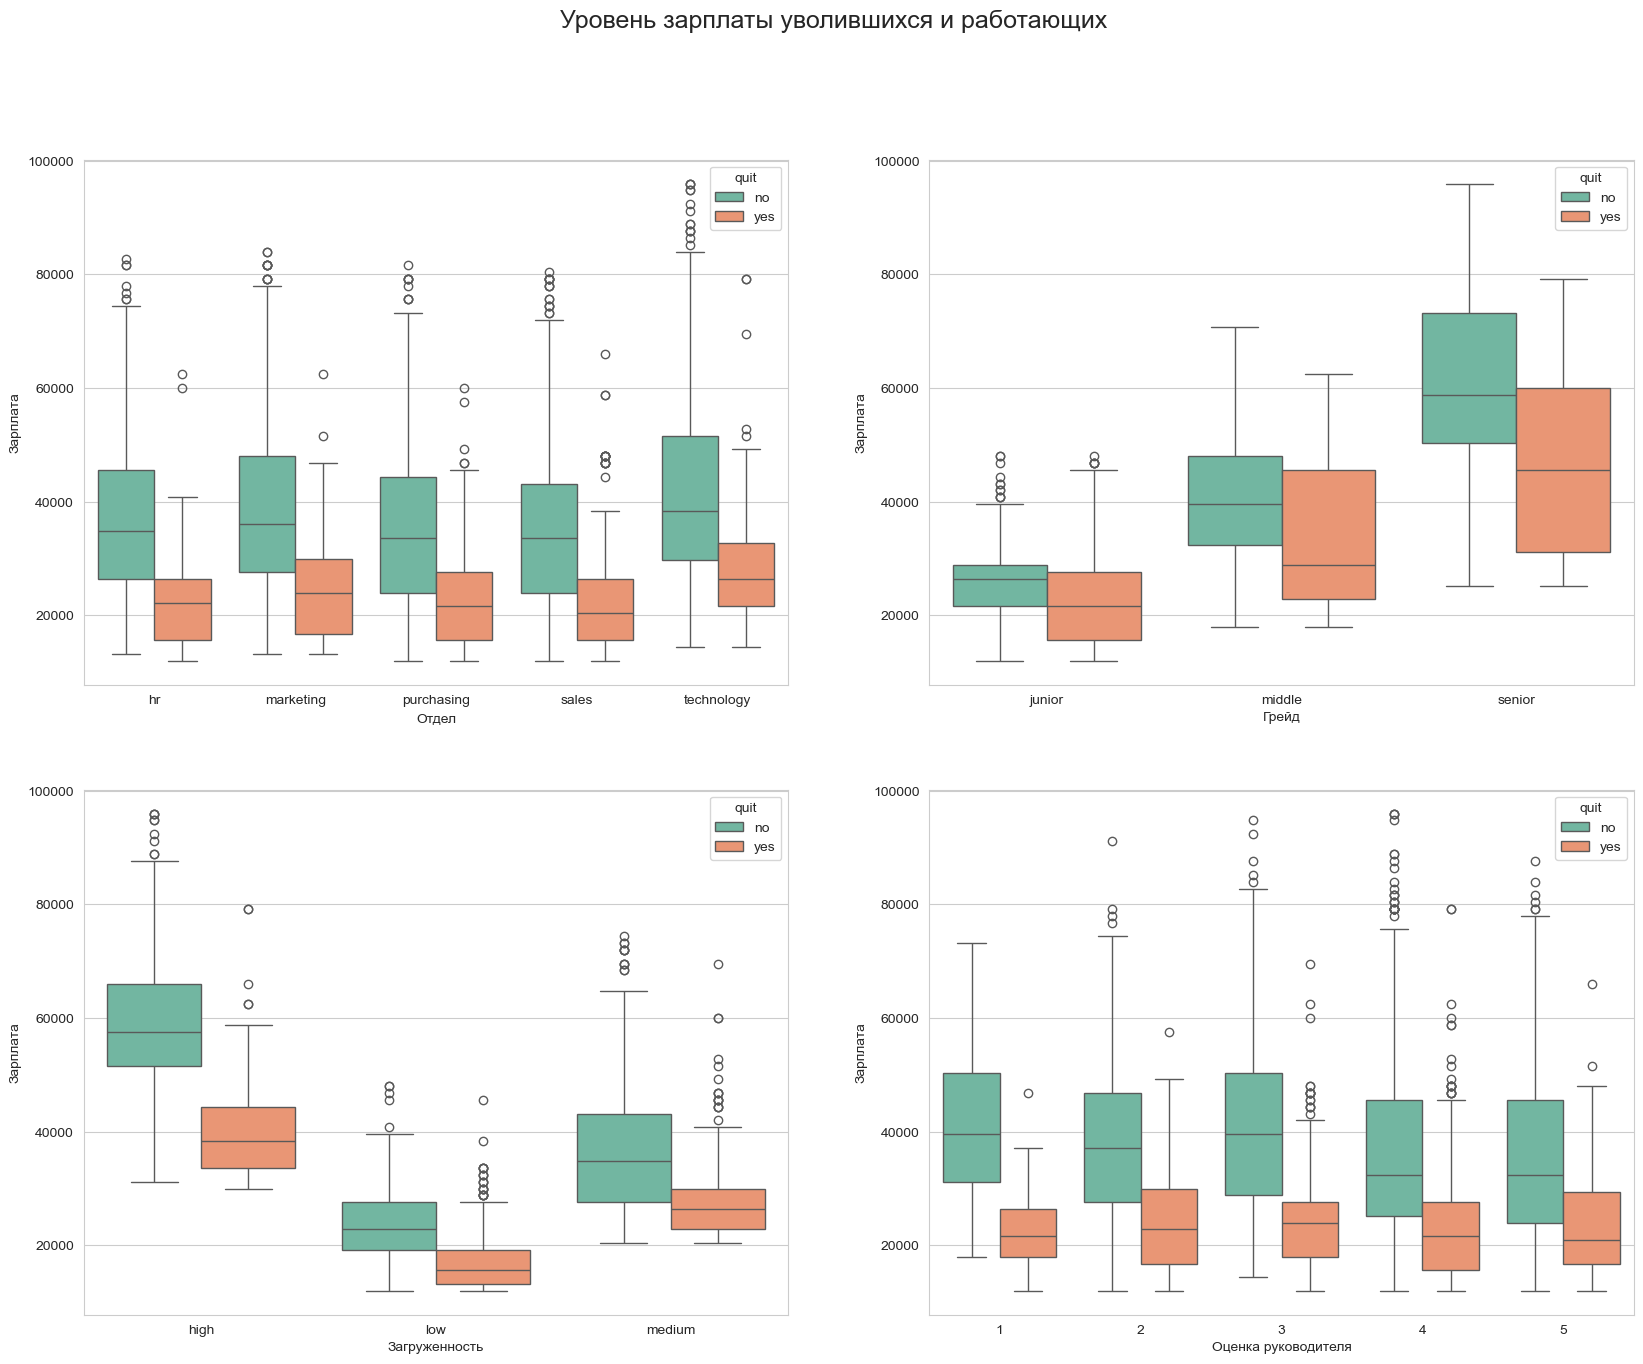

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
plt.suptitle('Уровень зарплаты уволившихся и работающих', fontsize=18)
sns.boxplot(x='dept', y='salary', hue='quit', 
            palette='Set2', data=train_quit, ax=axes[0,0]).set(xlabel='Отдел', ylabel='Зарплата');
sns.boxplot(x='level', y='salary', hue='quit', 
            palette='Set2', data=train_quit, ax=axes[0,1]).set(xlabel='Грейд', ylabel='Зарплата');
sns.boxplot(x='workload', y='salary', hue='quit', 
            palette='Set2', data=train_quit, ax=axes[1,0]).set(xlabel='Загруженность', ylabel='Зарплата');
sns.boxplot(x='supervisor_evaluation', y='salary', hue='quit', 
            palette='Set2', data=train_quit, ax=axes[1,1]).set(xlabel='Оценка руководителя', ylabel='Зарплата');

сравним зарплатв уволившихся сотрудников с зарплатами тех, кто решил не увольняться:

Распределение по признаку salary среди уволившихся сотрудников


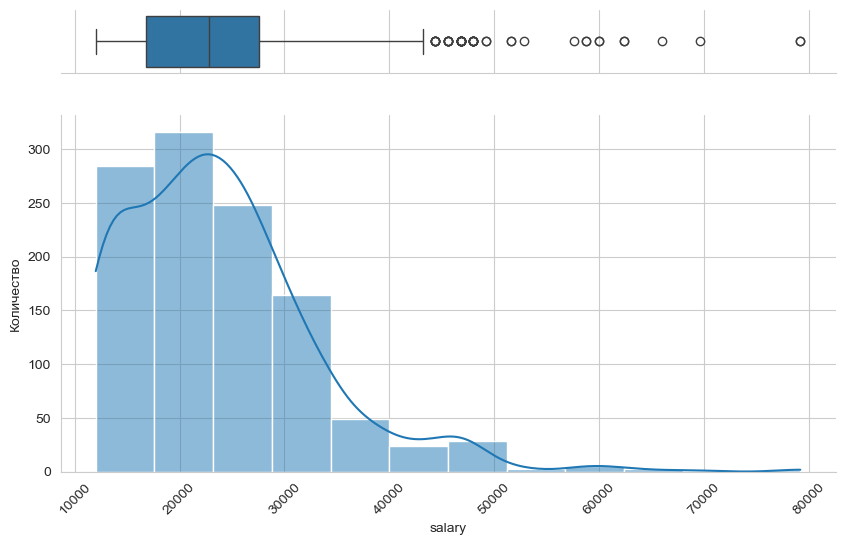

Распределение по признаку salary среди оставшихся сотрудников


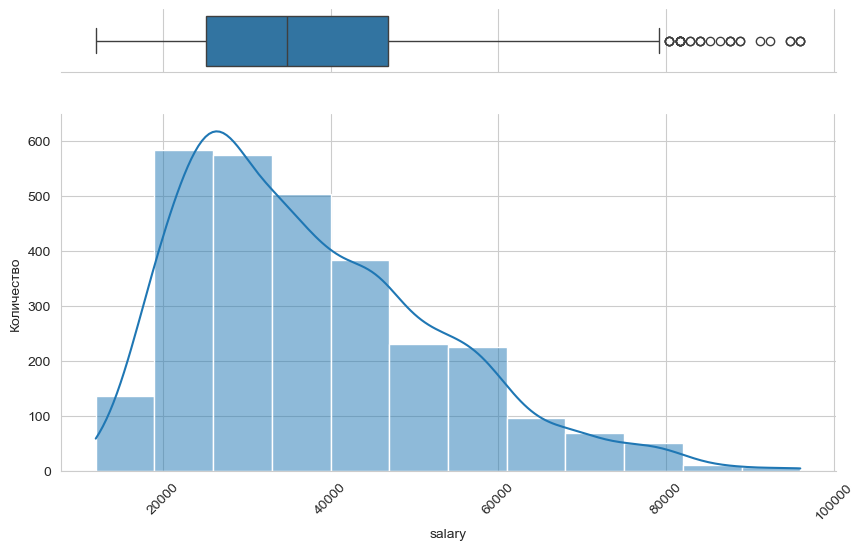

In [65]:
print("Распределение по признаку salary среди уволившихся сотрудников")
data_box_hist(train_quit[train_quit['quit'] == 'yes']['salary'])
print("=="*60)
print("Распределение по признаку salary среди оставшихся сотрудников")
data_box_hist(train_quit[train_quit['quit'] == 'no']['salary'])

с помощью графиков нам удалось выявить черты, наиболее характерные для человека, готового к увольнению: это junior, работающий в компании год, имеющий низкую загруженность работы и невысокую оценку от руководства. также мы выяснили, что уволившиеся сотрудники получали стабильно меньше, чем те, кто продолжает работать: в любом отделе, при любой загруженности, грейде и оценке шефа. 

очевидно, из компании чаще уходят новички, не увидевшие для себя перспектив профессионального развития.

#### Гипотеза аналитиков
**гипотеза** <br> 
уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. <br>
проверм это утверждение.

In [66]:
quit_data = test_features.merge(test_target_quit, on='id')
quit_data_full = quit_data.merge(test_target_job, on='id') 
quit_data_full

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,yes,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,yes,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,no,0.43


In [67]:
target = quit_data_full[['job_satisfaction_rate','quit']].copy()
target['quit_label'] = target['quit'].map({'yes': 1, 'no': 0})
target[['job_satisfaction_rate','quit_label']].corr('spearman')

,job_satisfaction_rate,quit_label
job_satisfaction_rate,1.000000,-0.457454
quit_label,-0.457454,1.000000


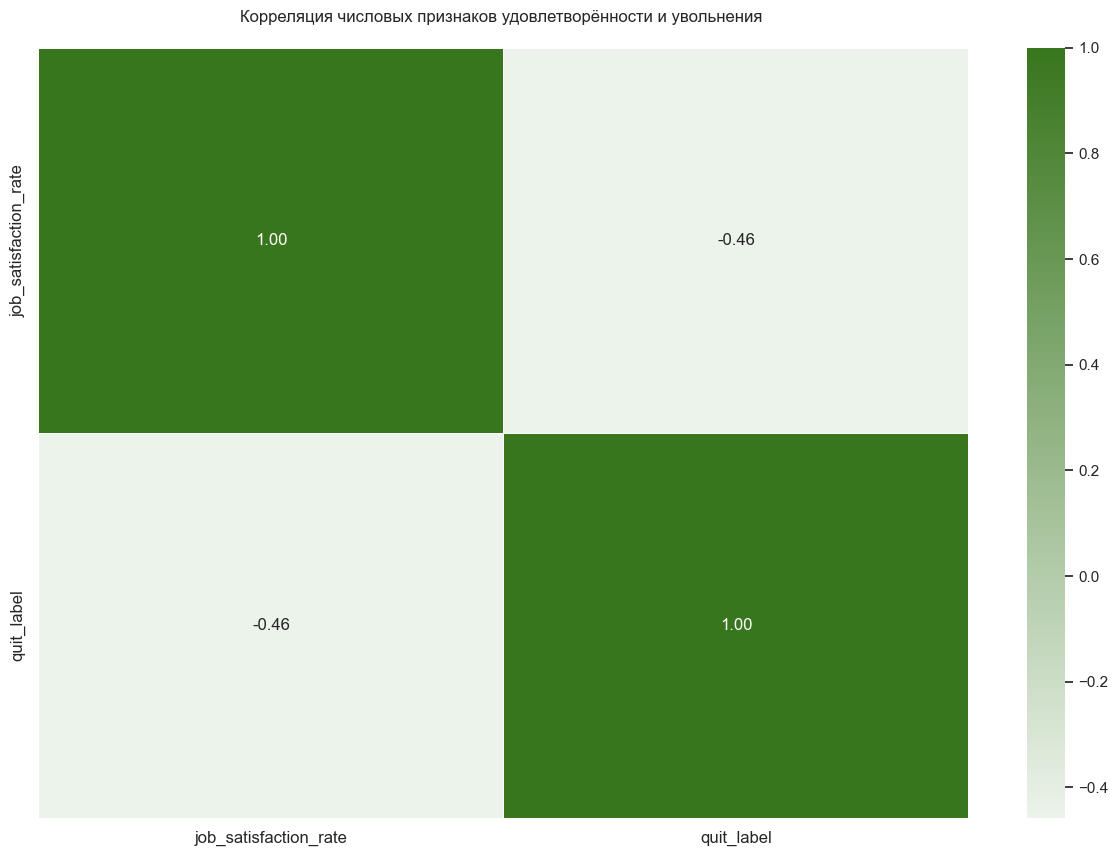

In [68]:
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (15, 10)})
sns.heatmap(target.select_dtypes(include=['number']).corr('spearman'), annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5)
plt.title('Корреляция числовых признаков удовлетворённости и увольнения \n')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

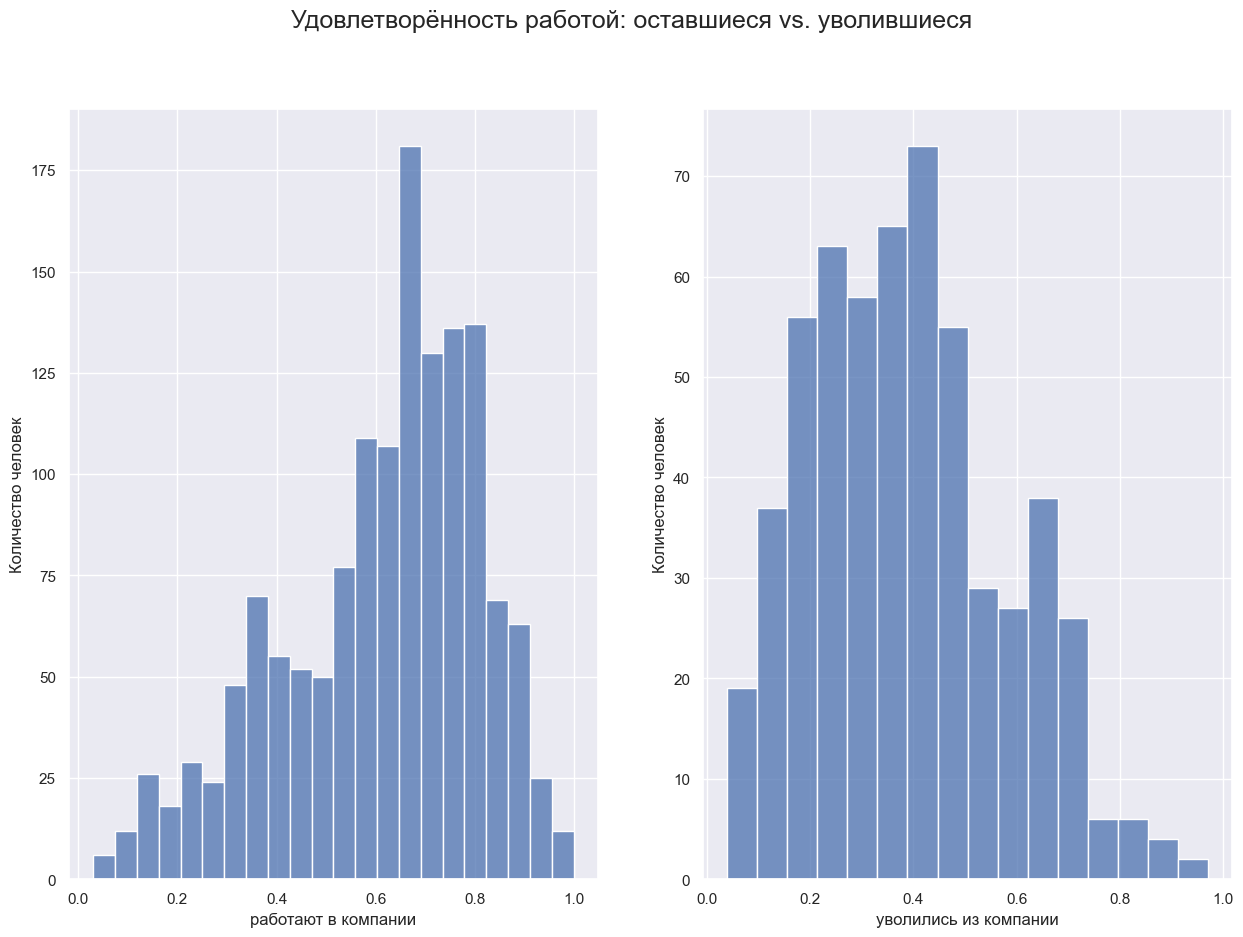

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
plt.suptitle('Удовлетворённость работой: оставшиеся vs. уволившиеся', fontsize=18)

sns.histplot(data = quit_data_full.loc[quit_data_full['quit']=='no'], 
             x='job_satisfaction_rate',
             ax=axes[0]).set(xlabel='работают в компании', 
                             ylabel='Количество человек');
sns.histplot(data = quit_data_full.loc[quit_data_full['quit']=='yes'],
             x='job_satisfaction_rate',
             ax=axes[1]).set(xlabel='уволились из компании', 
                             ylabel='Количество человек');
sns.set_style("whitegrid")
plt.show()

графики позволяют предположить, что удовлетворённость сотрудника может оказывать влияние на вероятность увольнения: у большей части уволенных сотрудников он оказывается ниже 0.5, в то время как у тех, кто остался в компании, он превышает 0.6.

### Добавление нового входного признака
добавим к входным признакам job_satisfaction_rate, предсказанный лучшей моделью в первой зкдаче исследования:

In [70]:
train_quit['job_satisfaction_rate'] = grid_search.best_estimator_.predict(
    train_quit.drop(columns = ['id', 'quit'])
)

In [71]:
test_features['job_satisfaction_rate'] = grid_search.best_estimator_.predict(
    test_features.drop(columns = ['id'], axis = 1)
)

In [72]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.833954
1,686555,hr,junior,medium,1,no,no,4,30000,0.653157
2,467458,sales,middle,low,5,no,no,4,19200,0.659685
3,418655,sales,middle,low,6,no,no,4,19200,0.665844
4,789145,hr,middle,medium,5,no,no,5,40800,0.810444


In [73]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.656658
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.833984
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.396244
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.331499
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.722797


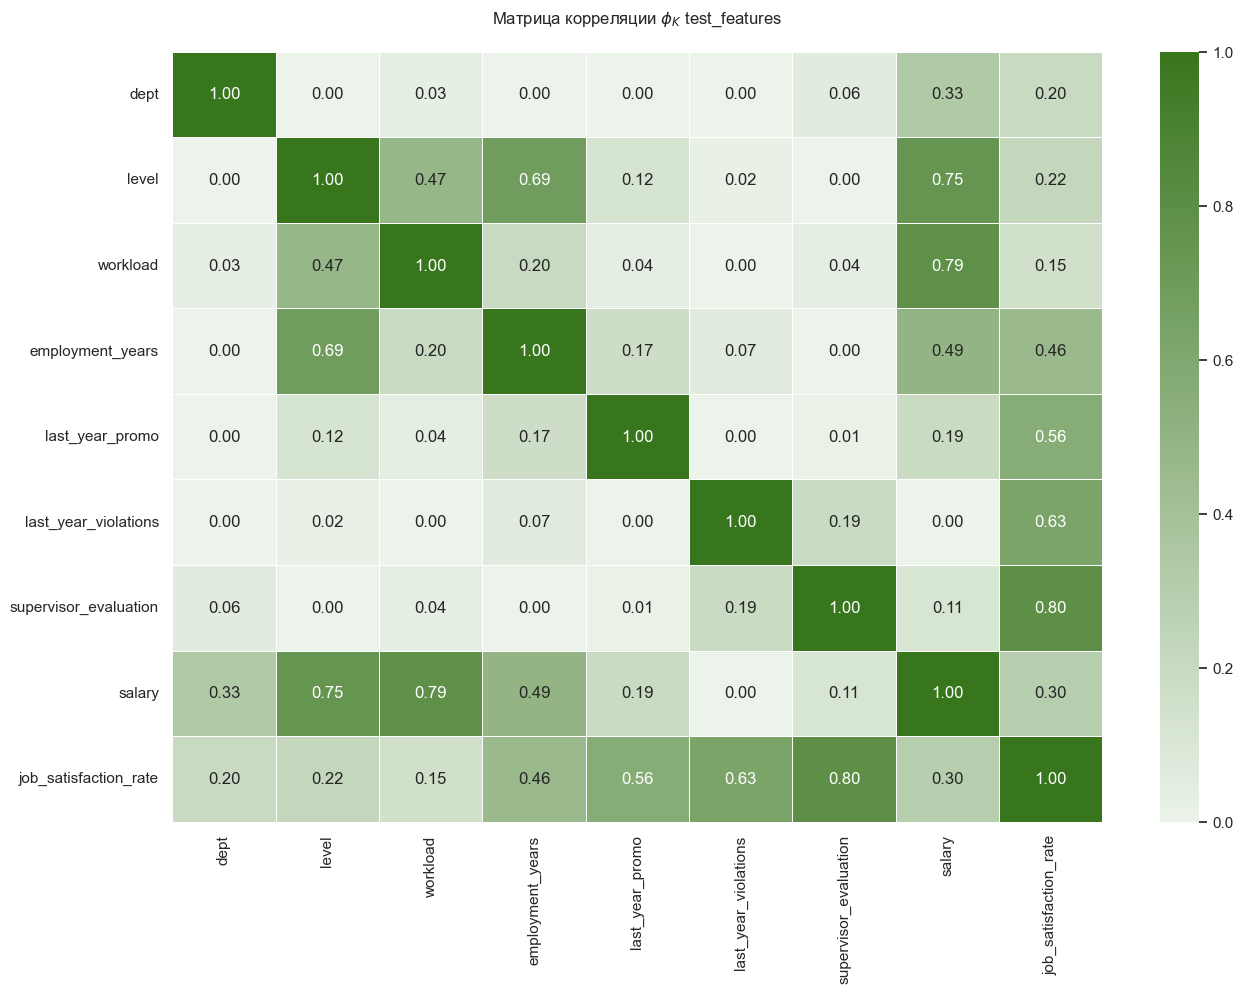

In [74]:
phik_test_features = test_features.drop(columns = ['id'], axis = 1)
interval_columns = ['salary', 'job_satisfaction_rate']
phik_overview = phik_test_features.phik_matrix(interval_cols=interval_columns)

green_cmap = sns.light_palette("#38761d", as_cmap=True)
#sns.set(rc={"figure.figsize": (12, 9)})
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5)
plt.title('Матрица корреляции $\phi_K$ test_features \n')
plt.show()

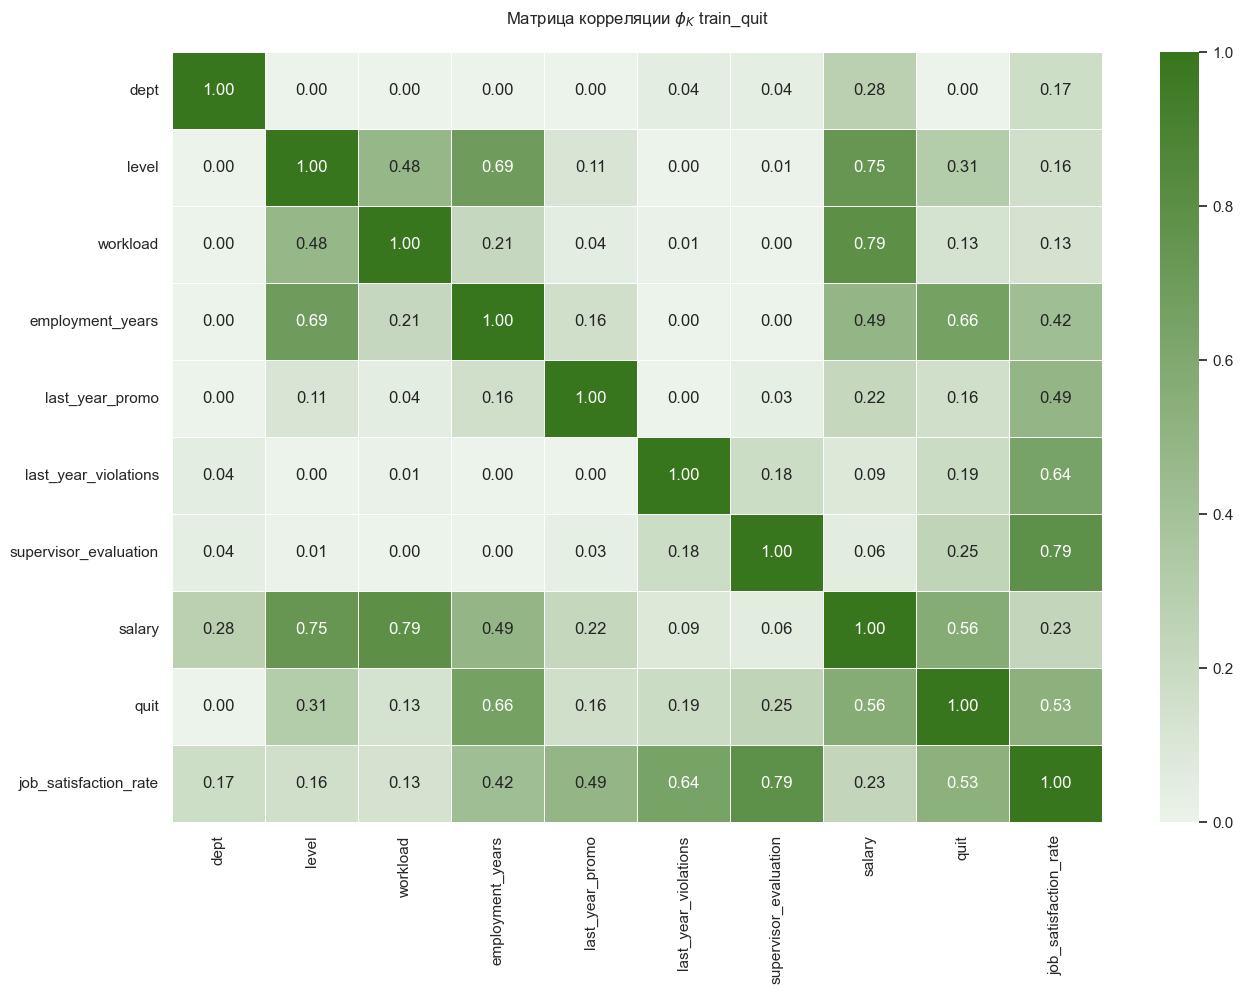

In [75]:
phik_train_quit = train_quit.drop(columns = ['id'], axis = 1)
interval_columns = ['salary', 'job_satisfaction_rate']
phik_overview = phik_train_quit.phik_matrix(interval_cols=interval_columns)

green_cmap = sns.light_palette("#38761d", as_cmap=True)
#sns.set(rc={"figure.figsize": (12, 9)})
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5)
plt.title('Матрица корреляции $\phi_K$ train_quit \n')
plt.show()

In [77]:
numeric_data = train_quit.select_dtypes(include=[np.number])
category_data = train_quit.select_dtypes(include=['category', 'object'])

category_ohe = pd.get_dummies(category_data, drop_first=True).astype(int)

X_encoded = pd.concat([numeric_data, category_ohe], axis=1)

X_encoded = X_encoded.astype(float)

X = sm.add_constant(X_encoded.iloc[:, 1:])

VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIFs.sort_values(by="VIF", ascending=False))

                    Variable         VIF
0                      const  136.956785
1                     salary   18.380945
9               workload_low   15.181001
24   supervisor_evaluation_4   13.257892
2      job_satisfaction_rate   12.108831
8               level_senior    9.554260
7               level_middle    8.310319
25   supervisor_evaluation_5    6.884669
10           workload_medium    6.642508
23   supervisor_evaluation_3    5.090450
16        employment_years_7    2.916334
6            dept_technology    2.724926
5                 dept_sales    2.698522
15        employment_years_6    2.694113
14        employment_years_5    2.693270
22   supervisor_evaluation_2    2.667760
17        employment_years_8    2.134232
11        employment_years_2    2.100776
4            dept_purchasing    1.960846
3             dept_marketing    1.956147
18        employment_years_9    1.916418
26                  quit_yes    1.892348
13        employment_years_4    1.819476
21  last_year_vi

ситуация, аналогичная той, что мы наблюдали в первой части исследования: классы некоторых признаков провоцируют мультиколлинеарность, однако мы по-прежнему не готовы срезать признакровое описание, но учтём эту проблему: помимо линейной модели мы будем применять другие модели, устойчивые к мультиколлинеарности.

### Подготовка данных, пайплайн и обучение
подготовим данные:

In [78]:
full_test_quit = test_target_quit.merge(test_features, on='id', how='left')

full_test_quit.info()
full_test_quit.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     2000 non-null   int64   
 1   quit                   2000 non-null   object  
 2   dept                   1997 non-null   category
 3   level                  1999 non-null   category
 4   workload               1999 non-null   category
 5   employment_years       2000 non-null   category
 6   last_year_promo        2000 non-null   category
 7   last_year_violations   2000 non-null   category
 8   supervisor_evaluation  2000 non-null   category
 9   salary                 2000 non-null   int64   
 10  job_satisfaction_rate  2000 non-null   float64 
dtypes: category(7), float64(1), int64(2), object(1)
memory usage: 77.6+ KB


,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.298473
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.187334
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.647852
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.665496
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.522701
5,223063,no,sales,middle,medium,6,no,no,4,38400,0.805924
6,810370,no,hr,junior,medium,1,no,no,5,26400,0.642831
7,998900,no,marketing,middle,medium,7,no,no,3,45600,0.491347
8,578329,no,sales,senior,medium,10,no,no,5,46800,0.684137
9,648850,no,sales,middle,high,9,no,no,5,57600,0.825359


In [79]:
X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']

X_test = full_test_quit.drop(['id', 'quit'], axis=1)
y_test = full_test_quit['quit']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 9)
(2000, 9)
(4000,)
(2000,)


In [80]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) 

In [81]:
le.classes_ = np.array(['no', 'yes'])

In [82]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

In [83]:
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [84]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        ('ord',
        OrdinalEncoder(categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']],
                       handle_unknown='use_encoded_value',
                       unknown_value=np.nan)
        ),
        
        ('simpleImputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [85]:
data_preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough'
)

In [86]:
pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', DecisionTreeClassifier())
])

In [87]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
                   
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

обучение модели

In [88]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': range(2, 20),
                                         'models__max_features': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [89]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

### Тестирование и выводы

In [90]:
probabilities = randomized_search.predict_proba(X_test)[:,1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities))

Площадь ROC-кривой: 0.9284686827080741


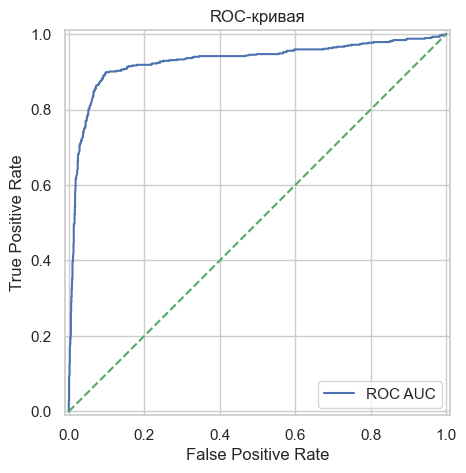

In [91]:
y_proba = probabilities

def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=None, estimator_name="ROC AUC").plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color='g', linestyle='--')
    plt.title("ROC-кривая")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

plot_auc_roc_curve(y_test, y_proba)

Метрика качества нашей модели `ROC-AUC = 0.93` на тестовой выборке, что превышает минимальный порог, определённый заказчиком (ROC-AUC ≥ 0.91)

## Общий вывод
Перед нами стояла задача проанализировать данные о сотрудниках компании и на основании этого построить модели для предсказания уровня удовлетворённости и вероятности увольнения.

**Этапы работы**:
1. *Предобработка данных*<br>
   данные были очищены от пропусков и некорректных значений, а также преобразованы в формат, пригодный для дальнейшего анализа.
2. *Исследовательский анализ данных*<br>
   проведено исследование данных, чтобы определить связи между переменными и выявить закономерности в данных.
3. *Подготовка данных* <br>
   данные были подготовлены для использования в машинном обучении, включая нормализацию и кодирование категориальных переменных.
4. *Выбор модели*<br>
   были выбраны модели VotingRegressor для предсказания уровня удовлетворённости сотрудников и StackingClassifier для предсказания вероятности увольнения.
6. *Гиперпараметры*<br>
   были определены оптимальные гиперпараметры для выбранных моделей.
7. *Обучение модели* <br>
   модели были обучены на подготовленных данных.

**В ходе исследования нам удалось установить**:
* Сотрудники с должностью junior, с низкой загруженностью работы, низкими оценками со стороны руководителя и непродолжительным стажем работы в компании наиболее часто подвергаются увольнению. <br>
* При этом намерение увролиться не опредеояется отделом, в котором работает сотрудник <br>
* В целом на момент увольнения заработная плата у уволившихся сотрудников была ниже, чем у оставшихся &mdash; данное утверждение справедливо для всех отделов и грейдов, а также не зависит от уровни загруженности и от того, насколько высоко ценил сотрудника руководитель

Также нам удалось определить усреднённый портрет сотрудника на грани увольнения:
* junior
* недавно нанятый
* не загруженный работой 
* имеющий невысокую оценку от руководства
* получающий зарплату меньшую, чем коллеги

Также мы установили, что: <br>
Уровень удовлетворённости сотрудника работой в компании может влиять на вероятность увольнения.

**Какое решение мы можем предложить бизнесу**:
* уделять больше внимания новоприбывшим джуниорам, показывая им возможности профессионального и карьерного роста внутри компании;
* систематически мониторить уровень заработной платы и оптимизировать системы грейдирования (если таковой в компании нет, то её целесообразно ввести);
* переработать концепцию мотивации сотрудников (бонусные выходные, частичная компенсация курсов при выполнении KPI)